In [1]:
import sys
sys.path.append('./library') # age_gender_predictor
sys.path.append('../.env/lib/python2.7/site-packages') # make sure it can get virtualenv lib
import age_gender_predictor
from datetime import datetime, timedelta
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
from nltk import PorterStemmer
import re
from scipy.sparse import hstack
from scipy.sparse import vstack
from copy import copy
import pandas as pd
import json
import os
from collections import defaultdict

## Loding scikit-learn models

In [2]:
def load_model(file_location):
    model = joblib.load(file_location)
    return model 

#Loding Bipolar Random Forest
bipolar_model = load_model("models/bipolar_forest/bipolar_forest_2week_modified")


## Process Data Function
### Age and gender Distribution

In [3]:
def getAgeGender(group):
    features = {"age":[],"gender":[]}
    for timeSeries in group:
        
        features["age"].append(getAge(timeSeries))
        features["gender"].append(getGender(timeSeries))

    return features
def getAge(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_age(texts)

def getGender(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_gender(texts)

### Social Feature

In [4]:
def getTweetRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    total_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    try:
        result = total_tweets / float(total_duration)
    except:
        result = total_tweets / 1.0
    return result

def getLateTweetRate(timeSeries):
    total_late = 0
    for index in timeSeries.index:
        if int(index.hour) <6:
            total_late += 1
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    total_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    try:
        result = total_late / float(total_duration)
    except:
        result = total_late / 1.0
    return result

def getMentionRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    total_mentions = np.sum(seriesContains(timeSeries))
    return total_mentions / float(total_tweets)

def thirdPronuonDetect(words, matcher=re.compile("@[a-z]+")):
    for word in words:
        if word == "@":
            continue
        elif matcher.search(word):
            return True
    return False

def seriesContains(timeSeries):
    match_function = np.vectorize(thirdPronuonDetect)
    return match_function(timeSeries["text"].str.lower().str.split().values)


def getUniqueMentions(timeSeries):
    total_tweets = timeSeries.shape[0]
    friends_set = set()
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_set.add(word)
    return len(friends_set)

def getFrequentMentions(timeSeries, lowerbound = 3):
    total_tweets = timeSeries.shape[0]
    friends_mentions = {}
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_mentions[word] = friends_mentions.get(word, 0) +1
    frequent_frients = [screen_name for screen_name, mentions in friends_mentions.items() if mentions >= lowerbound]
    return len(frequent_frients)
 

def getSocialFeature_group(group):
    social_features = {"tweets_rate": [],"mention_rate": [],"unique_mentions": [],"frequent_mentions": [], "late_tweets_rate": []}
    for timeSeries in group:
        social_features["tweets_rate"].append(getTweetRate(timeSeries))
        social_features["mention_rate"].append(getMentionRate(timeSeries))
        social_features["unique_mentions"].append(getUniqueMentions(timeSeries))
        social_features["frequent_mentions"].append(getFrequentMentions(timeSeries))
        social_features["late_tweets_rate"].append(getLateTweetRate(timeSeries))
    return social_features

def getAllFeature(group, tail_k = "all"):
    feature_set = {}
    methods = [getSocialFeature_group, getGroupEmotions, getPolarity, getAgeGender]
    for method in methods:
        feature_set.update(method(group.getGroup(tail_k)))
    return feature_set


### Polarity Feature

In [5]:
def getFlipsCount(timeSeries, upperbound=120, lowerbound = 0):
    flips = getFlips(timeSeries)
    durations = getFlipsDuration(timeSeries, flips)
    return np.sum((durations > lowerbound) & (durations < upperbound) )

def getFlips(timeSeries, attribute= 'polarity'):
    flips = np.zeros(timeSeries.shape[0],dtype=bool)
    polarity = timeSeries[attribute].values[:-1]
    right_elements = timeSeries[attribute].values[1:]
    flips[:-1] = (polarity * right_elements) < 0
    return flips

def getFlipsDuration(timeSeries, flips):
    filtered_timeSeries = timeSeries['dt'][flips].index.values
    dt = np.zeros(filtered_timeSeries.shape[0],dtype=float)
    dt[:-1] = (filtered_timeSeries[1:] - filtered_timeSeries[:-1]).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return dt

def getCombosCount(timeSeries, matcher = -1, lowerbound = 2):
    combos = comboTracker(timeSeries)
    combos_count = sum([hit for element, hit in combos if element == matcher and hit > lowerbound])
    return combos_count

def getNegativeRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == -1) / float(total_tweets)

def getPositiveRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == 1) / float(total_tweets)

def getPolarity(group):
    polarity = {"flips":[],"negative_combos":[],"positive_combos":[], "positive_ratio":[], "negative_ratio":[]}
    for timeSeries in group:
        try:
            tweets_length = float(timeSeries.shape[0])
        except:
            print 'error'
            print timeSeries
            break
        flips_ratio = getFlipsCount(timeSeries) / tweets_length
        negative_combos_ratio = getCombosCount(timeSeries,matcher=-1) / tweets_length
        positive_combos_ratio = getCombosCount(timeSeries,matcher=1) / tweets_length
        positive_ratio = getPositiveRatio(timeSeries)
        negative_ratio = getNegativeRatio(timeSeries)
        
        polarity["flips"].append(flips_ratio)
        polarity["negative_combos"].append(negative_combos_ratio)
        polarity["positive_combos"].append(positive_combos_ratio)
        polarity["positive_ratio"].append(positive_ratio)
        polarity["negative_ratio"].append(negative_ratio)
        
    return polarity

def comboTracker(timeSeries, attribute= "polarity", lowerbound = 120):
    array = timeSeries[attribute]
#     the polarity of starter
    starter = array[0]
    combo = 1
    result = []
    i = 0 
#     begin from second one in the array
    for cursor in array[1:]:
        i += 1
        if starter == cursor and timeSeries["dt"][i-1] < lowerbound:
            combo += 1
        else:
            if combo > 1:
                result.append((starter, combo))
            starter = cursor
            combo = 1
    if combo > 1:
         result.append((starter, combo))
    return result

### Emotion Feature

In [6]:



def getUsersEmotionsDict(users_timeSeries):
#     user -> emotion count
    user_emotion_dict = defaultdict(lambda: {"joy":0,
                                       "sadness": 0,
                                       "fear":0,
                                       "anticipation": 0,
                                       "anger":0,
                                       "trust": 0,
                                       "disgust": 0,
                                       "surprise" : 0
                                      })
    for user in users_timeSeries:
        user_tweets_count = 0
#         date, [tweet_info, tweets_info ...]
        for date, tweets_infos in users_timeSeries[user].iteritems():
            if date_not_in_range(user, datetime.strptime(str(date), "%Y%m%d")): continue
            for tweet_info in tweets_infos:                
    #             content, emotion1, emotion2, ambiguous
                if(tweet_info[3].strip() != 'yes'):
    #         only get the first emotion now
                    user_emotion_dict[user][tweet_info[1]] += 1
                    user_tweets_count += 1
    
        for emotion in user_emotion_dict[user]:
            if user_tweets_count == 0:
                user_emotion_dict[user][emotion] = 0
            else:
                user_emotion_dict[user][emotion] = float(user_emotion_dict[user][emotion]) / user_tweets_count
    return user_emotion_dict

def getUsersEmotions(timeSeries):
    non_ambiguous = np.invert(timeSeries["ambiguous"].values)
    
    filtered_emotions = timeSeries["emotion"][non_ambiguous].values
    emotions_count = {"joy":0,"sadness": 0,"fear":0,\
                "anticipation": 0, "anger":0, "trust": 0, "disgust": 0 ,"surprise" : 0}
    if float(filtered_emotions.shape[0]) == 0:
        divider = 1.0
    else:
        divider = float(filtered_emotions.shape[0])
    for emotion in emotions_count:
        emotions_count[emotion] = np.sum(filtered_emotions == emotion) / divider
    return emotions_count

def getGroupEmotions(group):
    emotions_counts = {"joy":[],"sadness": [],"fear":[],\
                "anticipation": [], "anger":[], "trust": [], "disgust": [] ,"surprise" : []}
    for timeSeries in group:
        emotions_count = getUsersEmotions(timeSeries)
        for emotion, count in emotions_count.items():
            emotions_counts[emotion].append(count)
    return emotions_counts



In [76]:
def getPOLFeature(user_timeSeries_list):
    features = np.zeros((len(user_timeSeries_list),20),dtype=float)
    for i, timeSeries in enumerate(user_timeSeries_list):
        
        tweets_length = float(timeSeries.shape[0])
        tweets_rate = getTweetRate(timeSeries)
        late_tweets_rate = getLateTweetRate(timeSeries)
        mention_rate = getMentionRate(timeSeries)
        unique_mentions = getUniqueMentions(timeSeries)
        frequent_mentions = getFrequentMentions(timeSeries)
        negative_ratio = getNegativeRatio(timeSeries)
        positive_ratio = getPositiveRatio(timeSeries)
        flips_ratio = getFlipsCount(timeSeries) / tweets_length
        negative_combos = getCombosCount(timeSeries) / tweets_length
        positive_combos = getCombosCount(timeSeries,matcher=1) / tweets_length
        emotion_counts_dict = getUsersEmotions(timeSeries)


        age = getAge(timeSeries)
        gender = getGender(timeSeries)

        features[i][0] = tweets_rate
        features[i][1] = late_tweets_rate
        features[i][2] = mention_rate
        features[i][3] = unique_mentions
        features[i][4] = frequent_mentions 
        features[i][5] = positive_ratio
        features[i][6] = negative_ratio
        features[i][7] = flips_ratio
        features[i][8] = negative_combos
        features[i][9] = positive_combos
        features[i][10] = age
        features[i][11] = gender
        for j, emotion in enumerate(["joy","sadness","fear", "anticipation", "anger", "trust", "disgust" ,"surprise"]):
            features[i][12+j] = np.mean(emotion_counts_dict[emotion])
        
            
    return features

# Predict

In [77]:
def pol_report(timeline):
#     A list of 8-weeks-timeSeries timeline
    timeSeries_list = getTimeSeries(timeline)
    features = getPOLFeature(timeSeries_list)
    
    user_timeline_reports = []
    for i, feature in enumerate(features):
        timeSeries = timeSeries_list[i]
#         print(bipolar_model.predict_proba(feature))
        bipolar_proba = bipolar_model.predict_proba(feature)[0][0][1]

        report = {}
        report["tweets_length"] = timeSeries_list[i].shape[0]
        report["tweeting_frequency"] = feature[0]
        report["late_tweeting_frequency"] = feature[1]
        report["mentioning_frequency"] = feature[2]
        report["unique_mentioning"] = feature[3]
        report["frequent_mentioning"] = feature[4]
        report["positive_ratio"] = feature[5]
        report["negative_ratio"] = feature[6]
        report["flips_ratio"] = feature[7]
        report["negative_combos"] = feature[8]
        report["positive_combos"] = feature[9]
        report["age"] = features[0][10]
        report["gender"] = "Male" if features[0][11] < 0 else "Female"
        report["bipolar_probability"] = bipolar_proba
        
        user_timeline_reports.append(report)

    return user_timeline_reports


### Load Predict File

In [9]:
def checkFolderFile(folder):
    return os.listdir(folder)

# ## Read BD_user
def loadTweets(folder, filename, tweets_dict):
    with open(folder + filename, 'r') as openfile:
        for line in openfile.readlines():
            try:
                username, date, datetime, content, sentiment, emotion1, emotion2, ambiguous = line.split('\t')
            except:
                print(line.split('\t'))
            tweets_dict[username][int(date)].append((datetime, content, sentiment, emotion1, emotion2, ambiguous.strip()))
    return tweets_dict

In [41]:
def date_not_in_range(user, ill_time_dict, date):
    if date >= ill_time_dict[user] - timedelta(weeks=6) \
    and date <= ill_time_dict[user] + timedelta(weeks=3):
        return False
    else:
        return True
def timeSeriesTransform(usersEmotions):
    for userID in usersEmotions:
        usersEmotions[userID] = pd.DataFrame.from_dict(usersEmotions[userID], orient='index').fillna(0)
        usersEmotions[userID]['dt'] = np.zeros(usersEmotions[userID].shape[0],dtype=float)
        usersEmotions[userID].loc[:-1,'dt'] = (usersEmotions[userID].index[1:].values - usersEmotions[userID].index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return list(usersEmotions.values())

def getHTTPRows(timeSeries):
    count = 0
    patterns = ['http://','https://']
    conditions = timeSeries['text'].str.contains(patterns[0])
    for pattern in patterns[1:]:
        conditions = conditions | timeSeries['text'].str.contains(pattern)

    return conditions.values

def userFilter(group, spam_threshold=0.5,tweets_threshold=25, time_filter = False):    #Spam and inactive user filter
    #     to restrict date in latest 8 weeks
    if time_filter == True:
        temp_group=[]
        for timeSeries in group:
            eight_week_period = timeSeries.index[-1]- timedelta(weeks=8)
            temp_group.append(timeSeries[timeSeries.index > eight_week_period])
        group = temp_group
            
    new_group = []
    for timeSeries in group:
        http_rows = getHTTPRows(timeSeries)
        average_http_count = np.sum(http_rows) / timeSeries.shape[0]
        if (average_http_count < spam_threshold) and (timeSeries.shape[0] > tweets_threshold):
            new_group.append(timeSeries)
    return new_group

def TweetsFormating(tweets_dict, ill_time_dict=None,en_threshold=0.9):
    usersTweets = {}
    true_yes_dict = {'yes':True, 'no':False, 'None': True}
    for user in tweets_dict:       
        userID = user
        if ill_time_dict is not None:
            if user not in ill_time_dict: continue
        for date_ in tweets_dict[user]:
#             if date_not_in_range(user, ill_time_dict ,datetime.strptime(str(date_), "%Y%m%d")): continue
            for tweet_info in tweets_dict[user][date_]:
                date, content, polarity, emotion1, emotion2, ambiguous = tweet_info
   
                date = datetime.strptime(str(date), "%Y-%m-%d %H:%M:%S") - timedelta(hours = 8) #Modify the time! Because get all tweets is from taiwan(+8) not +0
                text = content
                
                if userID not in usersTweets:
                    usersTweets[userID] = {}
                if date not in usersTweets[userID]:
                    usersTweets[userID][date] = {}
                usersTweets[userID][date]['name'] = userID
                usersTweets[userID][date]['text'] = text
                usersTweets[userID][date]['polarity'] =  int(polarity.strip())
                
                
                usersTweets[userID][date]['emotion'] =  emotion1
                usersTweets[userID][date]['emotion_2'] =  emotion2
                usersTweets[userID][date]['ambiguous'] =  true_yes_dict[ambiguous]

    return usersTweets
    

In [33]:
def readPatientIllTime(folder, filename):
    with open(folder + filename, 'r') as openfile:
        return [line.strip().split('\t') for line in openfile.readlines()]
    
# ## Get ill time information
patient_ill_time_list = readPatientIllTime('./', 'bipolar_list')
patient_ill_time_dict = {line[0]: line[1] for line in patient_ill_time_list}

# dict[user][diagnosed_time(datetime)]
patient_month_time_dict = {}

for patient in patient_ill_time_dict:
    datetime_list = patient_ill_time_dict[patient].split('/')
    if len(datetime_list) > 1:
        if len(datetime_list) > 2:
            patient_month_time_dict[patient] = datetime(int(datetime_list[0]), int(datetime_list[1]), int(datetime_list[2]))
        else:
            patient_month_time_dict[patient] = datetime(int(datetime_list[0]),int(datetime_list[1]),1)
    else:
        continue
del patient_ill_time_list
print( 'Patient Counts from month ill time:' + str(len(patient_month_time_dict)))

Patient Counts from month ill time:272


In [42]:
user_folder = 'patient emo_senti/'
# {username:{int(date):{[(datetime,content,sentiment,emotion1,emotion2,ambiguous),...]}}}
bd_tweets_dict = defaultdict(lambda: defaultdict(lambda:[]))
for user in checkFolderFile(user_folder):
    bd_tweets_dict = loadTweets(user_folder, user, bd_tweets_dict)

In [43]:
len(bd_tweets_dict)

182

In [44]:
bd_tweets = TweetsFormating(bd_tweets_dict, patient_month_time_dict)
del bd_tweets_dict

In [45]:
len(bd_tweets)

182

In [46]:
bd_timeSeries = timeSeriesTransform(bd_tweets)
bd_clean = userFilter(bd_timeSeries, spam_threshold=0.8, tweets_threshold=5)

In [47]:
len(bd_clean)

180

### 8 Week Slide Windows

In [49]:
# 8 weeks sliding windows, move 1 week per time
def slideWindows(timeline, start):
    
    limit = start + timedelta(weeks=8)
    
    status = False
    if timeline.index[-1] < limit: status = True
    
    new_start = start + timedelta(weeks=1)
    
    return timeline[timeline.index < limit], new_start, timeline[timeline.index > new_start],status
    
        
def getTimeSeries(timeline):
    timeSeries_list = []
    start = timeline.index[0]
    
    while True:
        timeSeries, start, timeline, status = slideWindows(timeline, start)
        timeSeries_list.append(timeSeries)
        if status: break
            
    return timeSeries_list

In [50]:
import warnings
import matplotlib.pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [51]:
import multiprocessing as mp

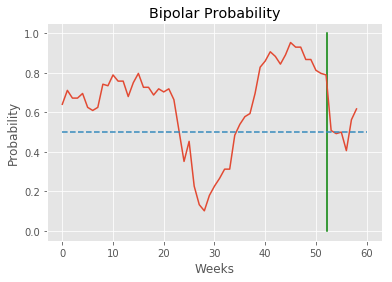

In [78]:
result = pol_report(bd_clean[4])
y = [window_info['bipolar_probability'] for window_info in result]
diagnosed_week = (patient_month_time_dict[bd_clean[4]['name'][0]] - bd_clean[4].index[0]).days / 7.0
plt.plot((diagnosed_week, diagnosed_week), (0.0, 1.0), 'g-')
plt.plot(y)
plt.plot((0, 60), (0.5, 0.5), '--')
plt.xlabel('Weeks')
plt.ylabel('Probability')
plt.title("Bipolar Probability")

plt.legend(loc="lower right")

plt.show()

0
NiallBunny
2016-06-20 00:00:00
2016-05-28 03:30:04
2016-09-19 09:06:48


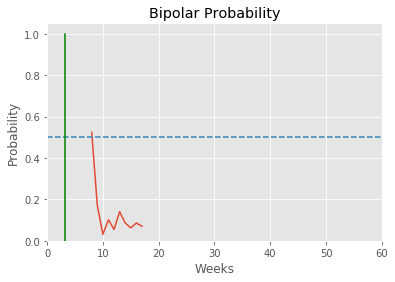

1
zozo_ed
2016-02-01 00:00:00
2015-01-31 18:39:27
2016-05-01 14:00:15


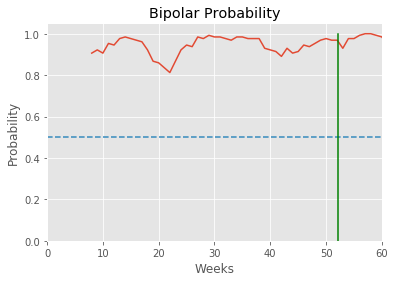

2
yobitchmiranda
2016-12-09 00:00:00
2015-12-08 21:36:43
2017-02-06 03:02:54


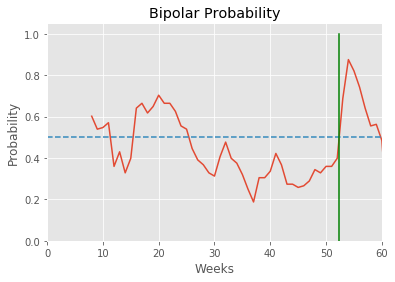

3
_raspberries
2016-03-04 00:00:00
2015-05-22 01:01:11
2016-06-04 05:27:04


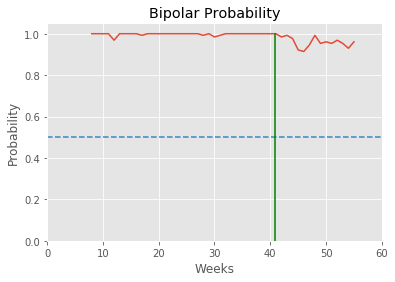

4
sanchezpaige
2013-06-19 00:00:00
2012-06-18 18:42:23
2013-09-19 15:31:05


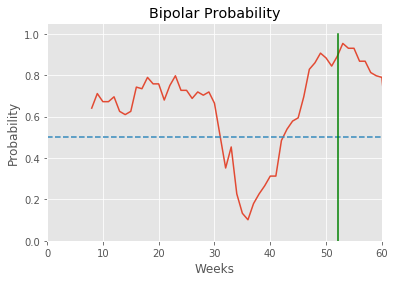

5
C_Leex3
2014-09-19 00:00:00
2014-09-29 06:05:58
2014-12-06 23:54:07


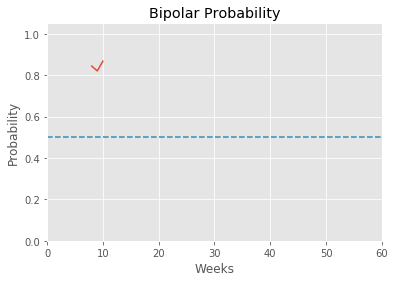

6
silencedrowns
2017-01-16 00:00:00
2016-01-15 19:16:26
2017-02-07 16:11:10


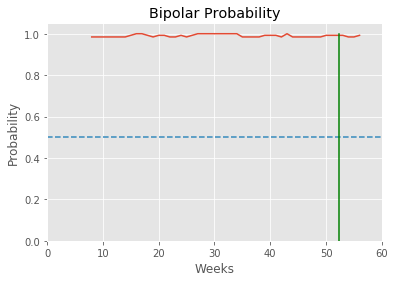

7
fmmshotme
2015-11-01 00:00:00
2015-12-09 07:43:45
2016-02-01 14:20:17


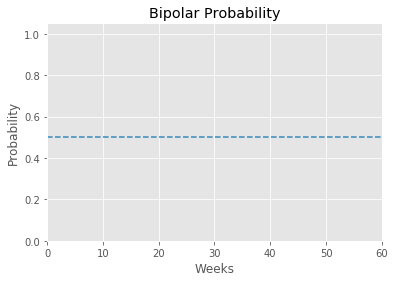

8
MUNTBABY
2014-02-13 00:00:00
2013-02-12 17:49:31
2014-05-13 15:46:41


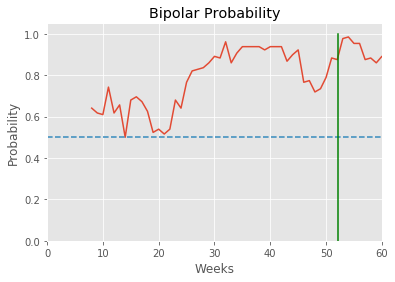

9
TommmMate
2017-01-22 00:00:00
2016-01-22 15:31:36
2017-02-03 17:40:56


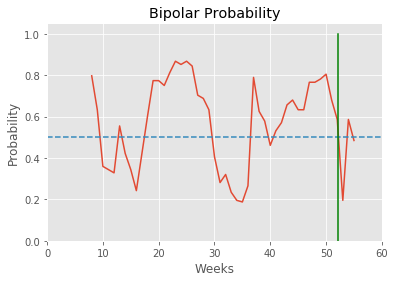

10
X_JuliiiiBabyyy
2015-07-09 00:00:00
2014-07-09 02:57:52
2015-10-09 06:03:58


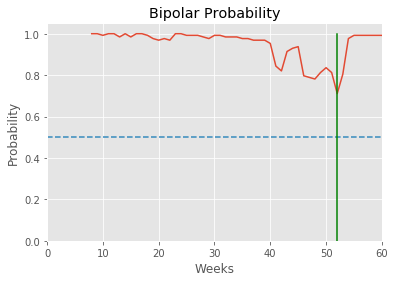

11
BreSwaGz
2016-06-01 00:00:00
2015-06-16 20:37:35
2016-09-01 14:11:39


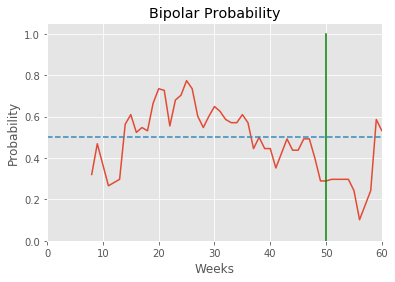

12
rozordie
2013-06-01 00:00:00
2012-05-31 16:00:43
2013-08-31 01:31:05


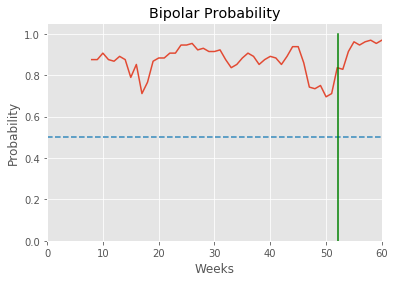

13
CEmmert25
2015-07-12 00:00:00
2014-11-08 05:11:31
2015-10-12 15:35:23


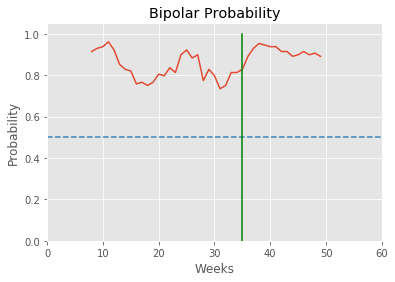

14
verybraveface
2013-12-10 00:00:00
2013-11-20 03:17:36
2014-03-10 15:57:13


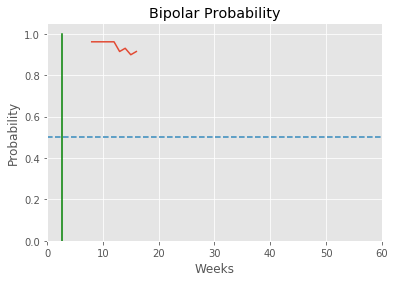

15
right2hell
2017-01-17 00:00:00
2016-12-30 07:54:35
2017-02-07 08:23:50


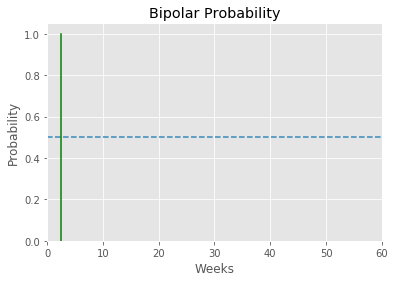

16
aleexturneer_
2014-01-01 00:00:00
2013-01-01 00:02:18
2014-04-01 14:49:39


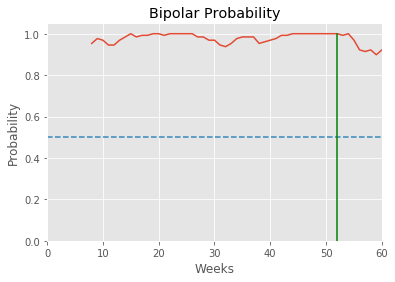

17
ElegantN7
2016-04-20 00:00:00
2015-04-20 07:31:02
2016-07-18 23:45:31
18
PennyCenturyXo
2014-01-28 00:00:00
2013-01-28 14:46:57
2014-04-27 20:28:59


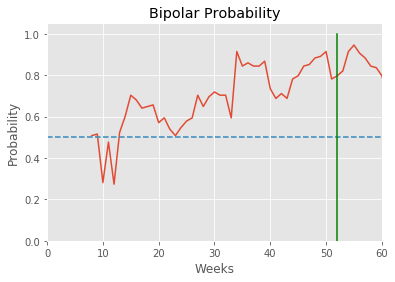

19
PlumBananas
2013-09-01 00:00:00
2012-09-04 14:47:36
2013-11-27 16:20:13


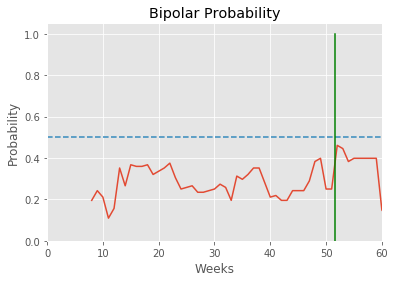

20
AwesomeAsh
2017-01-19 00:00:00
2016-01-22 06:18:02
2017-02-04 21:45:56


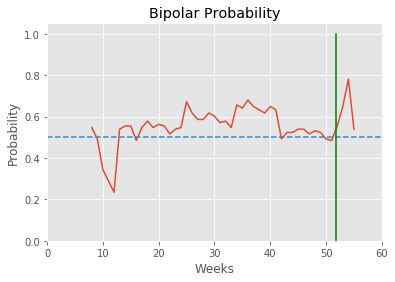

21
matthewRvincent
2017-01-21 00:00:00
2016-01-20 18:22:06
2017-02-05 18:41:37


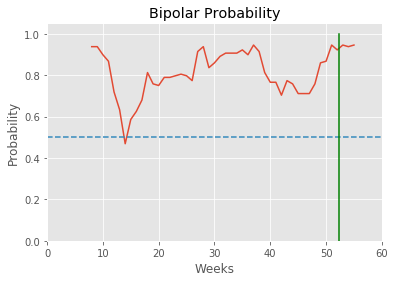

22
TionSavageee
2014-03-01 00:00:00
2013-02-28 17:03:26
2014-06-01 13:12:44


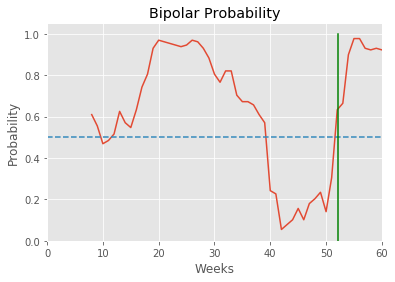

23
reportzoIo
2014-01-01 00:00:00
2013-01-01 00:09:14
2014-04-01 15:59:30


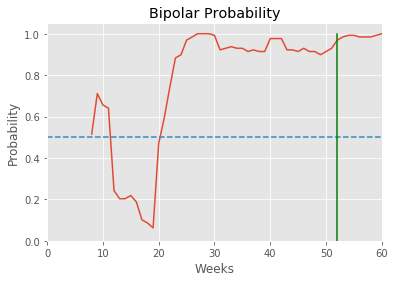

24
Erin_Louisee
2013-09-01 00:00:00
2012-08-31 20:12:29
2013-12-01 05:08:55


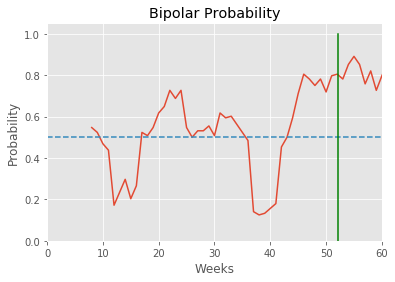

25
Jennys67
2014-02-06 00:00:00
2013-06-04 20:50:03
2014-05-04 03:47:21


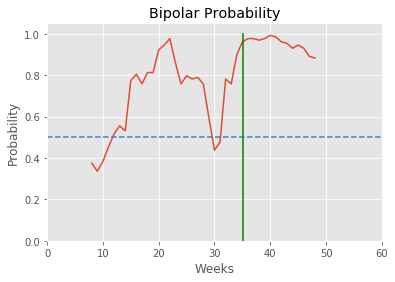

26
Vixoen
2013-06-01 00:00:00
2012-05-31 16:31:21
2013-09-01 07:28:50


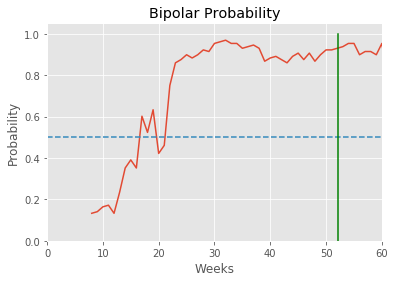

27
PunkRockHappy
2013-10-22 00:00:00
2012-10-23 23:55:05
2014-01-22 03:05:57


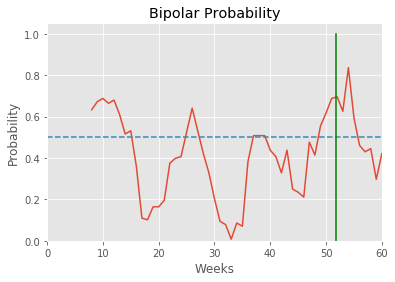

28
kakes_bakes
2012-09-01 00:00:00
2011-09-12 18:29:33
2012-11-21 02:07:38
29
complicatedcon
2017-01-11 00:00:00
2016-08-03 21:51:36
2017-02-06 06:58:50


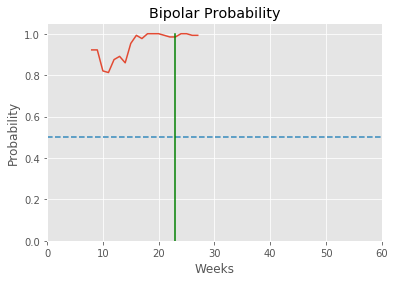

30
missmyerz9123
2015-12-18 00:00:00
2015-01-02 15:31:49
2016-03-17 15:44:27


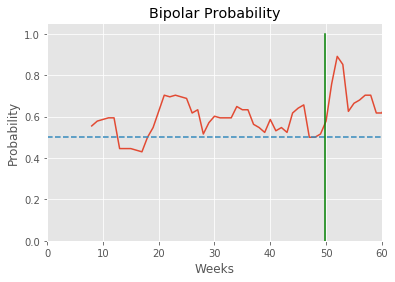

31
blue_moon_witch
2013-12-01 00:00:00
2014-01-21 18:14:28
2014-02-24 16:48:19


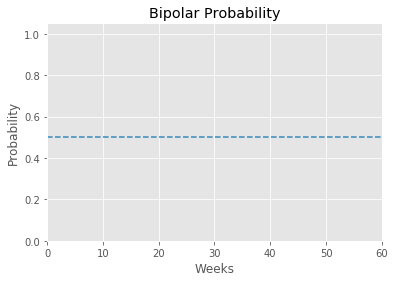

32
ValeourM
2013-09-01 00:00:00
2012-08-31 16:11:32
2013-12-01 08:06:27


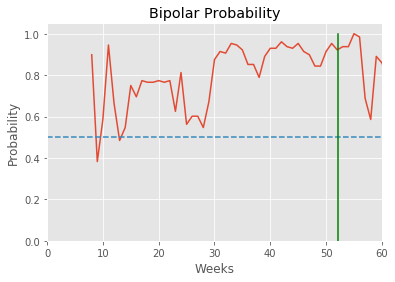

33
KashawnTaylor
2015-01-13 00:00:00
2014-01-12 17:06:45
2015-04-10 10:07:07


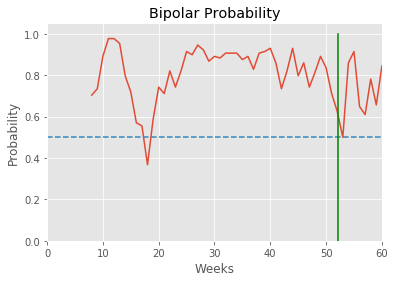

34
Ma7mood101
2014-06-19 00:00:00
2013-06-19 08:00:35
2014-09-17 12:10:16


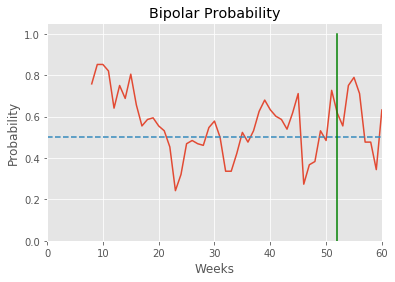

35
Boricua611
2015-08-01 00:00:00
2014-09-26 14:18:20
2015-11-01 03:18:12


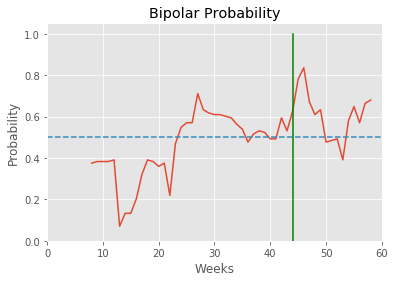

36
ddlovatoanangel
2013-09-17 00:00:00
2012-09-17 00:22:01
2013-12-16 09:03:58


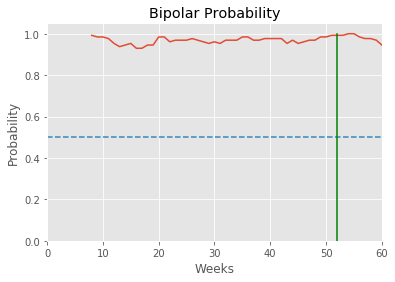

37
ChantyRomard
2016-10-16 00:00:00
2015-10-15 16:30:53
2016-12-22 13:26:24


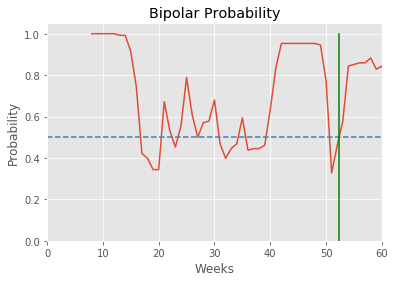

38
lil_miss_caf
2014-08-15 00:00:00
2013-08-14 16:00:57
2014-11-15 15:40:51


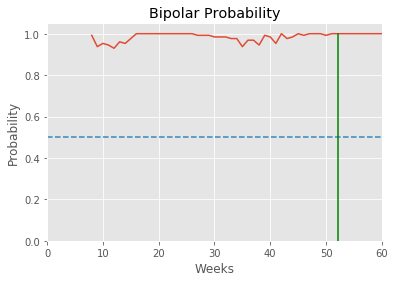

39
musicaIhoe
2016-01-27 00:00:00
2015-09-27 00:09:59
2016-04-22 05:49:48


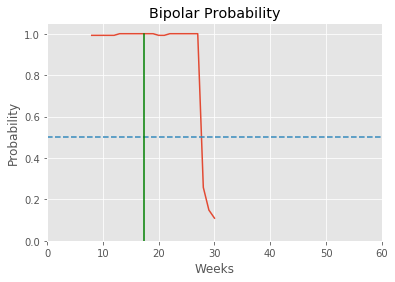

40
Scooby_Who
2012-10-01 00:00:00
2011-09-30 17:03:54
2013-01-01 15:42:54


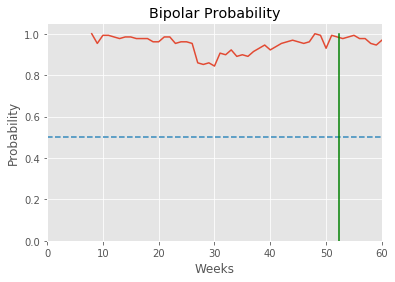

41
p_rapper
2013-02-01 00:00:00
2012-02-04 14:03:49
2013-04-04 06:50:39
42
dogcalledbambi
2014-06-18 00:00:00
2013-06-17 17:46:22
2014-09-17 22:04:14


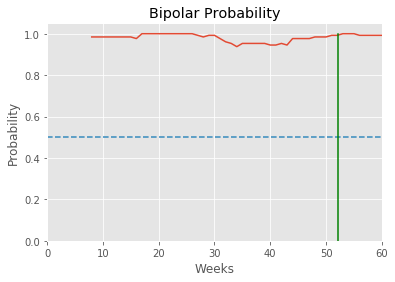

43
NeliaCarolyn
2013-11-14 00:00:00
2012-11-13 17:29:24
2014-02-14 15:46:17


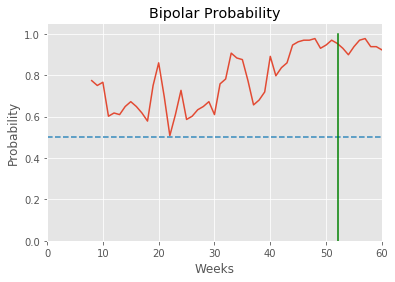

44
coolfamilyblog
2015-08-26 00:00:00
2014-08-27 03:34:51
2015-11-23 03:13:18


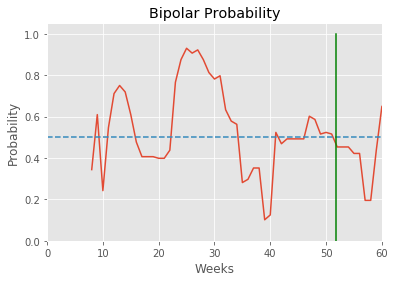

45
darrenleewelsh
2015-02-08 00:00:00
2014-05-11 03:43:56
2015-04-16 13:10:58
46
musicandincense
2014-12-04 00:00:00
2014-10-10 04:59:18
2015-02-16 13:31:35


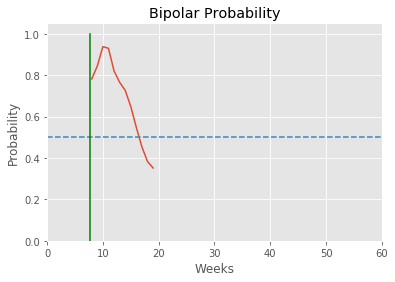

47
kawaiicutforth
2014-09-25 00:00:00
2014-08-05 01:35:17
2014-12-25 15:38:57


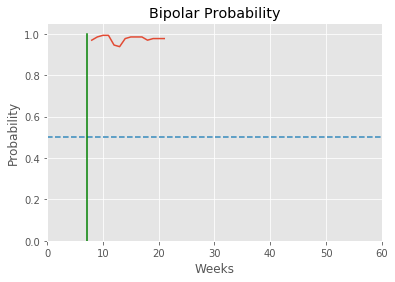

48
obliviousm3
2014-10-01 00:00:00
2014-06-16 19:18:12
2015-01-01 00:49:55


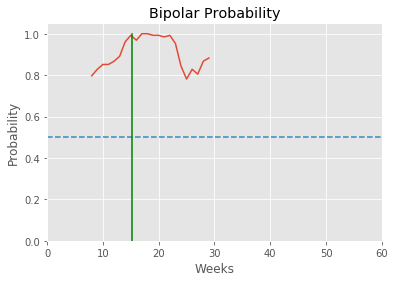

49
Lesh_taboo
2016-08-02 00:00:00
2015-08-01 23:23:27
2016-11-02 10:00:56


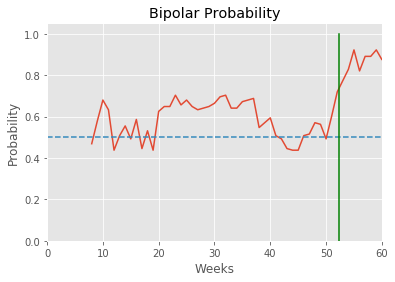

50
chucho109031995
2015-09-01 00:00:00
2015-05-04 03:21:27
2015-07-27 23:52:06


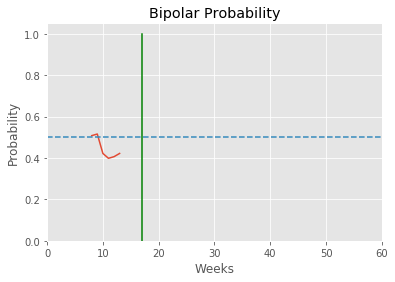

51
GeraintWaddon
2014-07-04 00:00:00
2013-07-04 06:50:17
2014-10-04 05:15:25


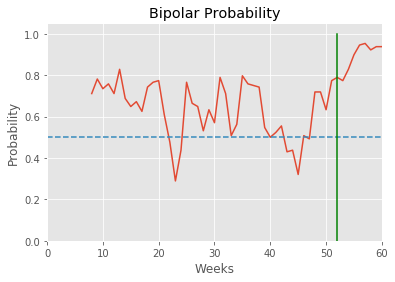

52
SammyFucknFenty
2015-04-01 00:00:00
2014-04-01 15:34:28
2015-07-01 14:48:13


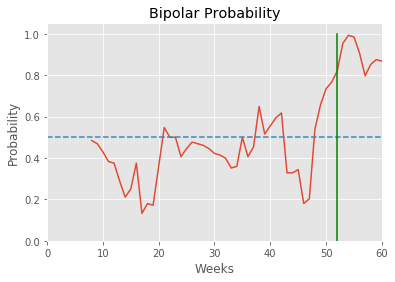

53
f0reverliving
2017-01-19 00:00:00
2016-01-20 17:27:04
2017-02-06 12:02:23


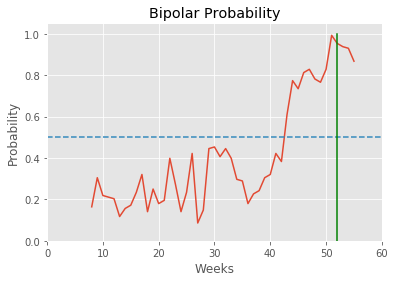

54
TheBornDreamer
2013-06-01 00:00:00
2012-06-01 23:53:11
2013-09-01 13:15:24


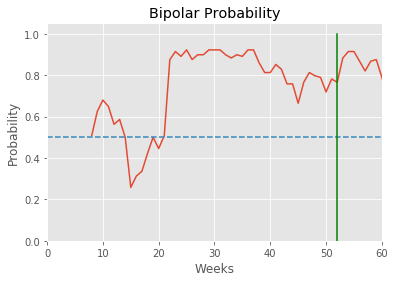

55
DatShitKrae
2015-11-13 00:00:00
2015-03-05 17:08:40
2016-02-12 16:06:36


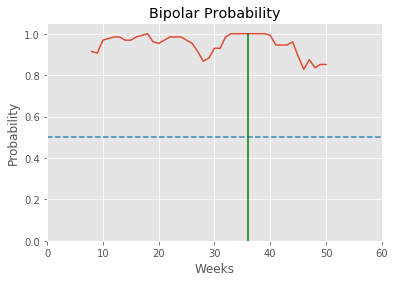

56
delaney_ashlyn
2014-06-20 00:00:00
2013-07-01 16:07:05
2014-09-20 12:58:22


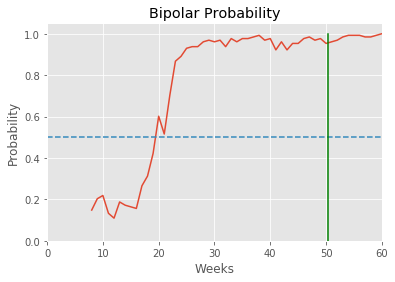

57
BossHossMOB
2016-08-03 00:00:00
2016-07-17 02:17:56
2016-11-03 14:41:01


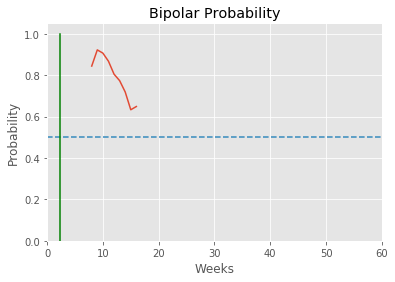

58
KARLXCARL
2015-03-01 00:00:00
2014-02-28 16:38:30
2015-06-01 15:10:40


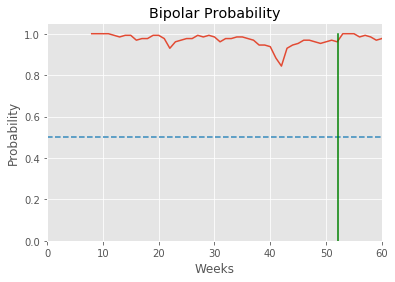

59
CassandraBurns7
2013-01-01 00:00:00
2012-09-27 19:36:41
2013-04-01 15:31:25


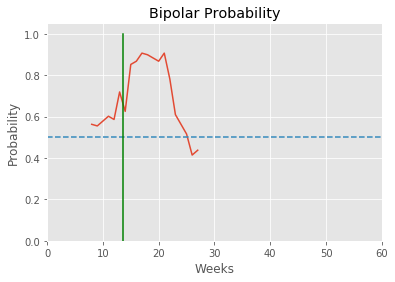

60
ArtistSomeday
2014-01-01 00:00:00
2013-01-20 01:58:26
2013-07-30 04:48:58
61
day0ldhat3
2015-04-07 00:00:00
2014-04-07 02:45:15
2015-07-07 09:49:19


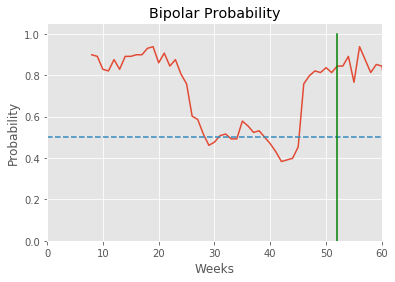

62
CMBogan
2016-02-18 00:00:00
2015-02-17 18:36:28
2016-05-08 19:23:23


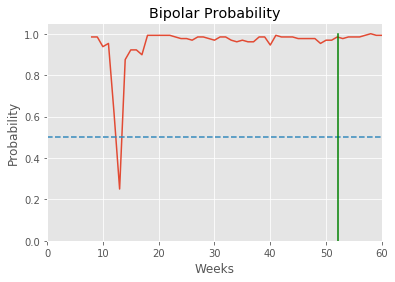

63
Radica_XO_Khidd
2014-11-13 00:00:00
2013-11-15 17:24:10
2015-02-11 19:53:25


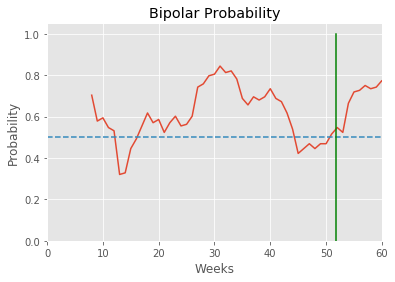

64
graham_bryan
2013-12-01 00:00:00
2013-04-13 16:49:40
2013-08-10 11:00:13
65
Dream_Star_
2013-04-01 00:00:00
2012-03-31 20:52:40
2013-07-01 12:09:59


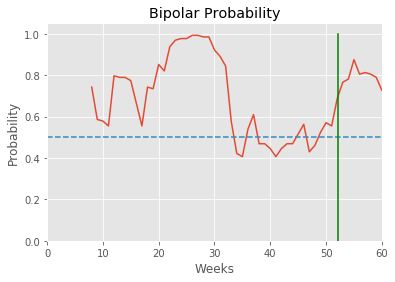

66
oldpaths_pub
2016-07-01 00:00:00
2016-04-10 16:13:01
2016-07-08 14:17:28


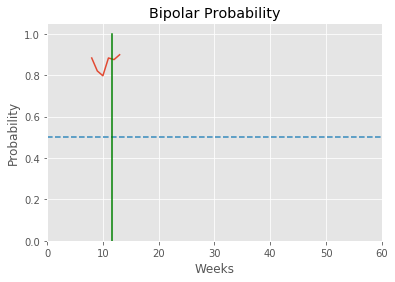

67
kuwabaras_
2016-10-25 00:00:00
2015-10-24 16:00:07
2016-12-29 03:51:37


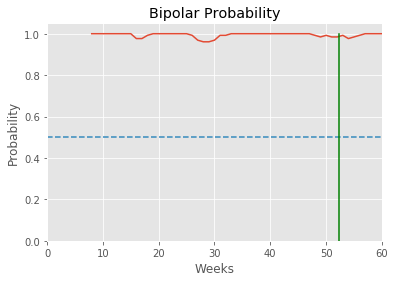

68
ninsnoopy
2014-08-15 00:00:00
2014-06-20 06:17:44
2014-11-15 06:06:43


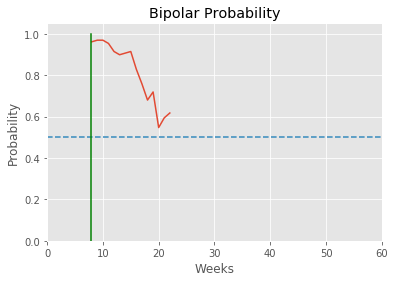

69
laurjbrown
2014-11-15 00:00:00
2013-12-09 05:29:02
2015-02-15 15:45:25


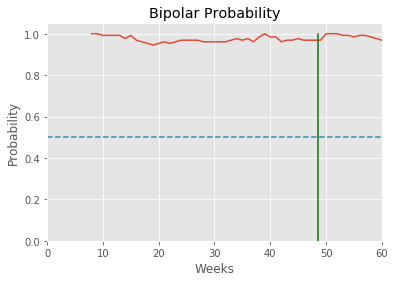

70
sammiethenami
2013-02-01 00:00:00
2012-08-28 12:29:58
2013-03-12 06:42:55
71
TylerCSmith815
2015-09-30 00:00:00
2014-10-30 15:28:48
2015-12-07 13:21:41
72
ceceliaa_
2013-08-01 00:00:00
2012-07-31 16:30:27
2013-10-14 07:12:06


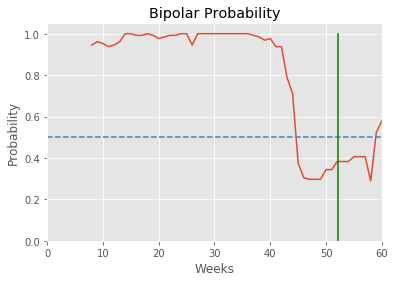

73
rosekelleher4
2016-01-27 00:00:00
2015-01-26 17:25:07
2016-04-27 01:16:25


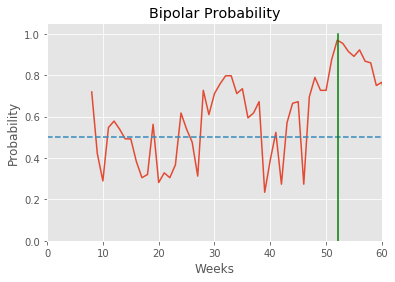

74
HeyThereJohana
2014-10-17 00:00:00
2013-10-17 01:24:22
2015-01-17 13:11:11


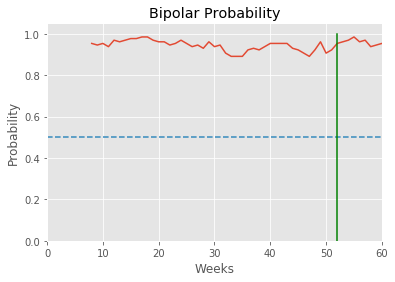

75
inaseaofemotion
2017-01-08 00:00:00
2016-09-14 19:42:05
2017-02-05 04:39:09


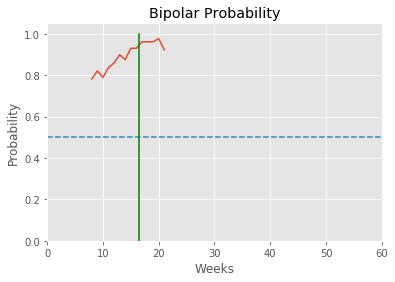

76
ActualJoykiller
2013-01-19 00:00:00
2012-01-19 23:10:11
2013-04-19 06:32:10


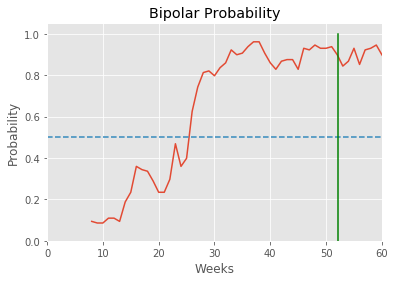

77
4lilpretentious
2017-01-12 00:00:00
2016-03-30 00:23:18
2017-02-07 22:26:24


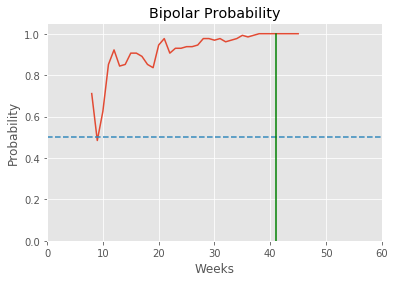

78
jgquinton
2013-10-03 00:00:00
2012-10-02 17:19:32
2014-01-03 06:01:29


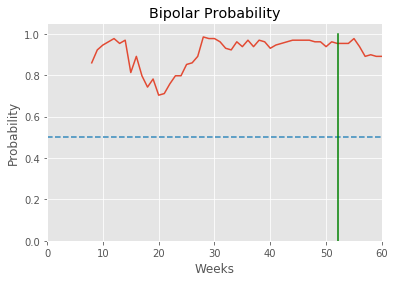

79
JonnyZombi
2016-03-07 00:00:00
2015-03-06 16:26:13
2016-06-07 03:11:19


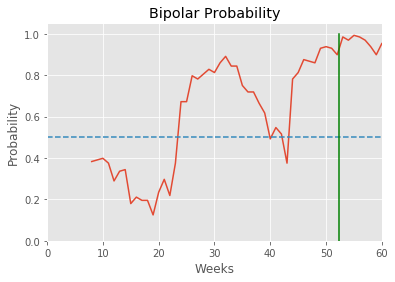

80
waxchinadoll
2015-07-01 00:00:00
2014-07-16 00:44:25
2015-10-01 01:27:32


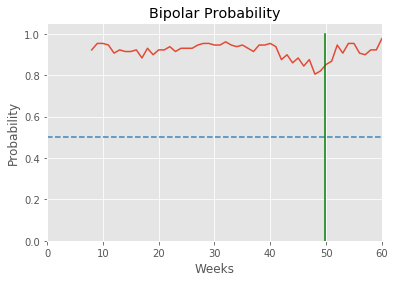

81
Karen_e_miller
2015-05-07 00:00:00
2014-05-06 23:08:31
2015-08-07 04:26:29


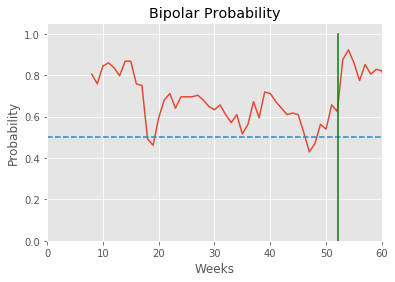

82
_KatKennedy
2014-03-01 00:00:00
2013-02-28 16:06:30
2014-06-01 04:40:21


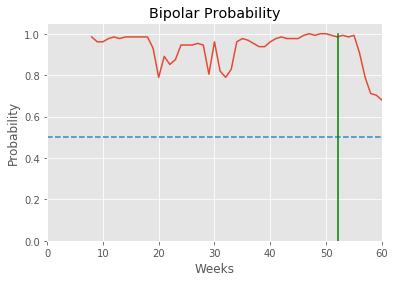

83
jamieboiss
2012-10-01 00:00:00
2011-10-11 21:55:51
2012-12-30 22:05:05


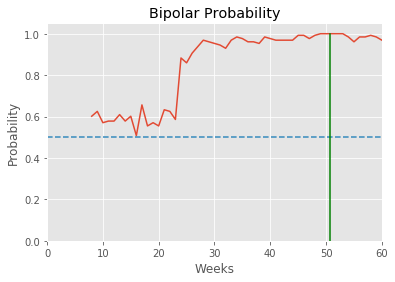

84
LithChronicles
2012-10-01 00:00:00
2012-04-02 20:35:53
2012-05-26 01:02:56


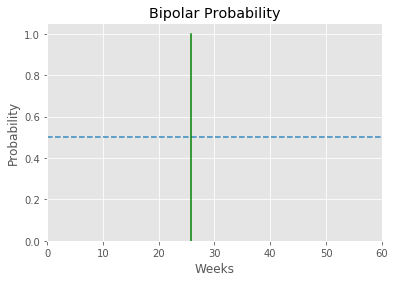

85
Popatrace_OrNah
2014-06-25 00:00:00
2013-06-25 06:33:52
2014-09-25 07:05:57


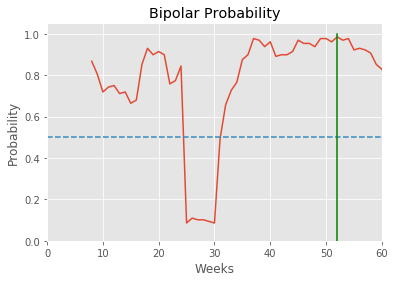

86
colinfarrelfan
2017-01-18 00:00:00
2016-01-18 04:57:11
2017-02-07 09:10:51


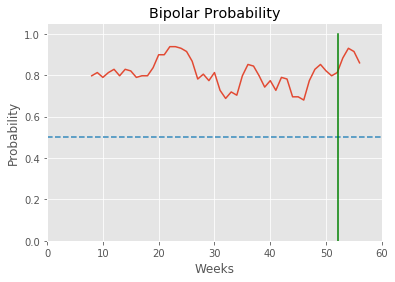

87
kristacathleen1
2015-06-01 00:00:00
2014-09-24 11:42:16
2015-08-04 01:58:01


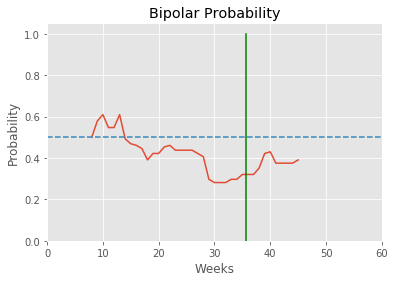

88
mcdoneugh
2015-07-20 00:00:00
2014-07-19 16:08:39
2015-10-17 16:33:03


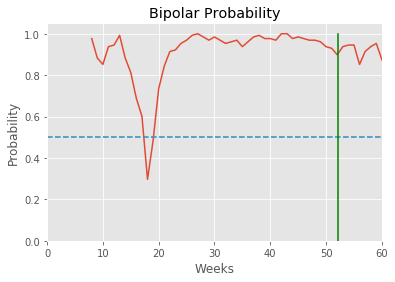

89
PinkBerryShake
2013-03-01 00:00:00
2012-02-29 17:36:52
2012-12-20 07:59:14


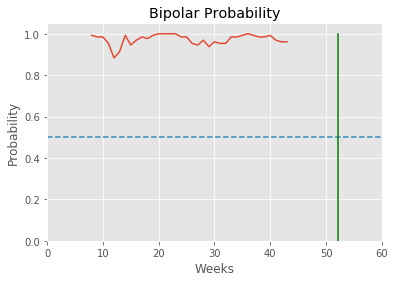

90
dave_ghost
2015-04-11 00:00:00
2014-05-28 00:52:08
2015-07-11 07:15:14


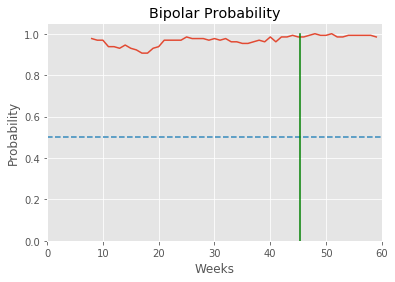

91
KissMyVibe
2013-08-01 00:00:00
2013-07-29 01:58:44
2013-10-26 01:48:14


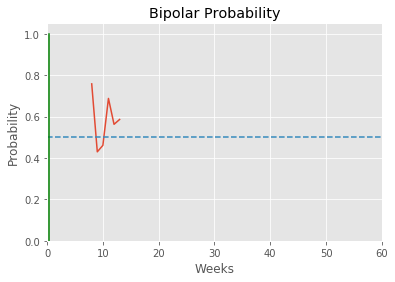

92
TammiJ1973
2012-09-11 00:00:00
2012-10-07 12:50:43
2012-12-11 15:44:06


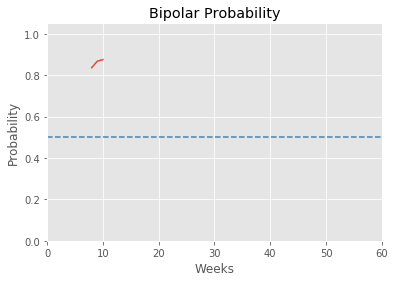

93
celineherbez
2012-02-01 00:00:00
2011-09-04 02:24:04
2012-05-01 10:44:37


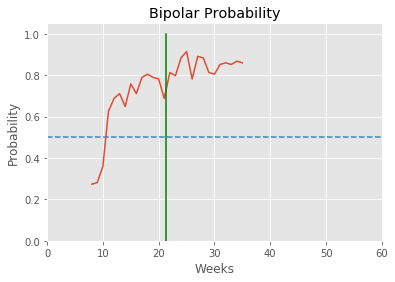

94
GingeKnievil
2014-12-02 00:00:00
2013-12-01 17:14:48
2015-03-02 15:23:42


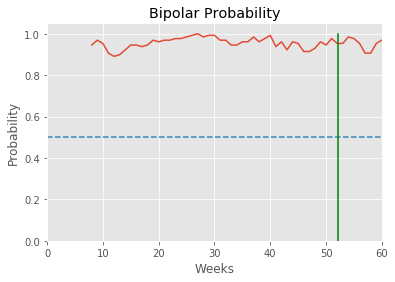

95
fadeaway94
2016-03-01 00:00:00
2015-10-25 15:12:25
2016-03-12 16:13:45
96
killingmyselfpl
2015-01-18 00:00:00
2014-08-04 06:27:04
2015-04-17 06:34:17


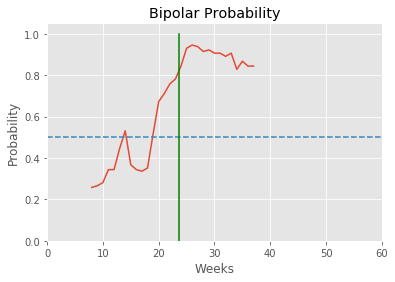

97
Alc43my
2016-11-09 00:00:00
2015-11-24 05:09:05
2016-12-27 21:51:16
98
io_superare
2015-11-01 00:00:00
2015-12-30 19:11:09
2016-01-29 05:25:20


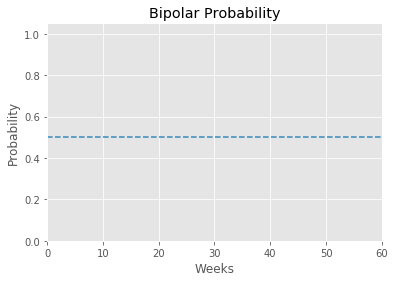

99
AndrewHoughton8
2013-12-20 00:00:00
2013-01-06 07:19:00
2014-03-18 18:12:13


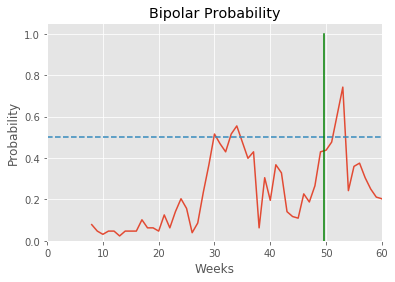

100
Cat_Fowl
2013-03-01 00:00:00
2012-02-29 23:47:52
2013-05-31 23:08:04


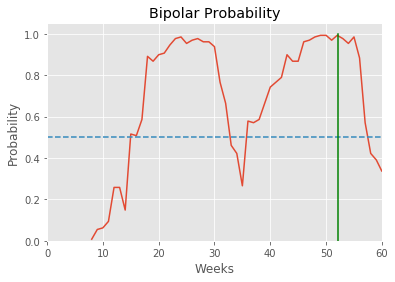

101
Demetria_Wife
2014-06-21 00:00:00
2013-06-20 16:21:34
2014-09-21 13:05:12


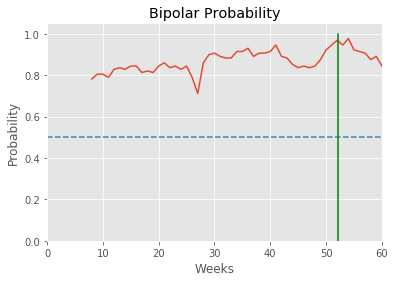

102
SassyPharmD
2014-11-10 00:00:00
2013-11-12 07:30:03
2015-02-10 13:54:59


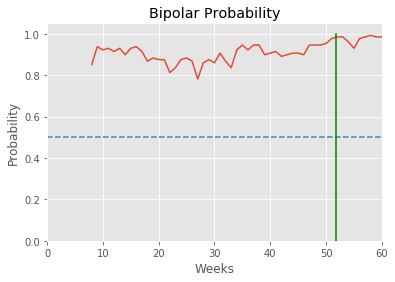

103
LostKaiyna
2014-12-01 00:00:00
2013-11-30 16:53:25
2015-02-27 19:59:28


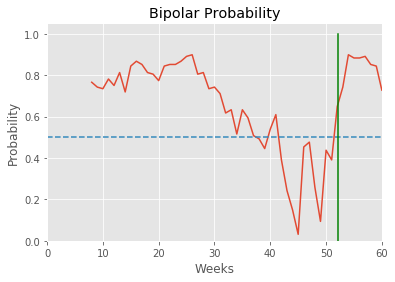

104
ashliewaters
2015-09-19 00:00:00
2014-09-21 07:35:40
2015-12-17 06:42:58


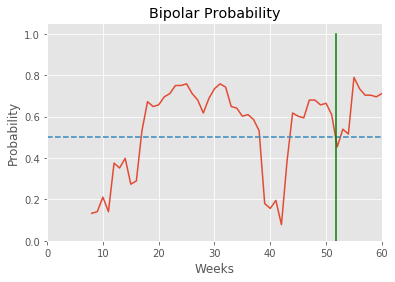

105
jxlsia
2012-08-04 00:00:00
2011-08-23 08:00:38
2012-11-04 13:50:38


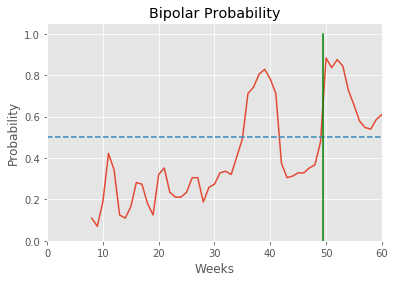

106
Anak_Bijak
2013-02-05 00:00:00
2012-05-26 18:58:29
2013-05-05 15:11:39


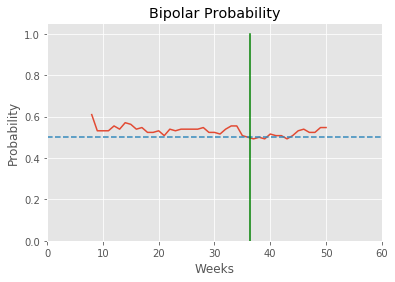

107
ghostofclifford
2016-05-15 00:00:00
2015-09-09 09:21:24
2016-08-15 14:30:25


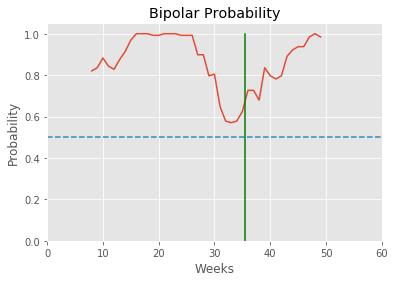

108
philomathspirit
2016-05-25 00:00:00
2015-05-24 17:38:25
2016-08-25 02:29:24


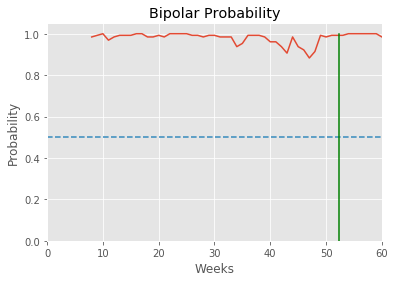

109
rorysxlogan
2015-04-02 00:00:00
2014-04-02 04:01:09
2015-07-02 06:08:25


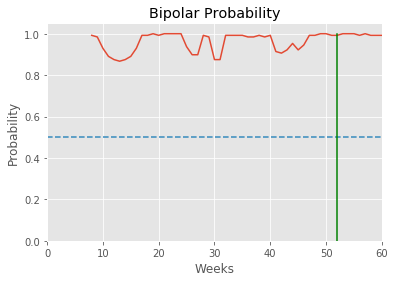

110
b_bylynn
2012-12-01 00:00:00
2012-10-01 19:59:43
2013-02-28 22:16:18


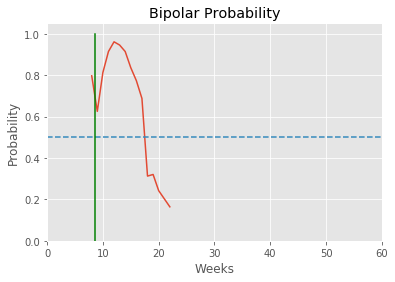

111
Ritz_Tweeting
2014-11-01 00:00:00
2013-10-31 16:48:16
2015-02-01 09:19:55


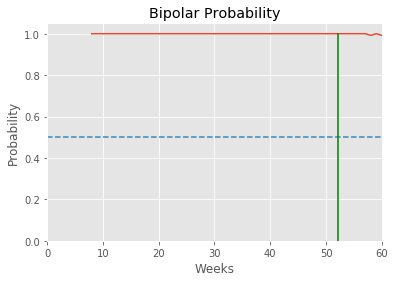

112
CourtneyDePatz
2016-11-11 00:00:00
2015-12-27 21:43:33
2016-12-28 06:09:00


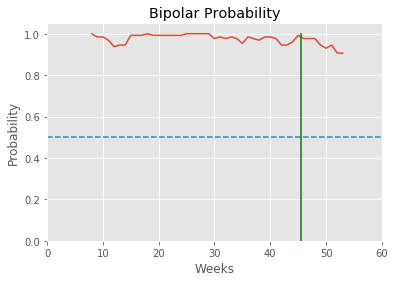

113
k3lvy_
2015-03-01 00:00:00
2014-02-28 20:39:05
2015-06-01 13:53:46


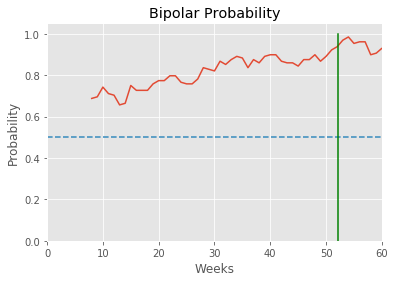

114
Leah_Pupzz
2014-10-01 00:00:00
2014-06-24 09:08:11
2015-01-01 08:54:59


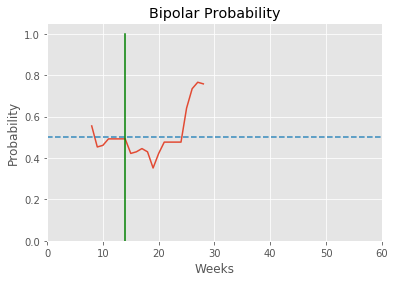

115
Beardy_Mc_Beard
2014-10-20 00:00:00
2013-10-21 04:48:07
2015-01-20 15:49:37
116
matea_friend
2014-04-07 00:00:00
2013-04-06 23:49:52
2014-07-06 09:42:20


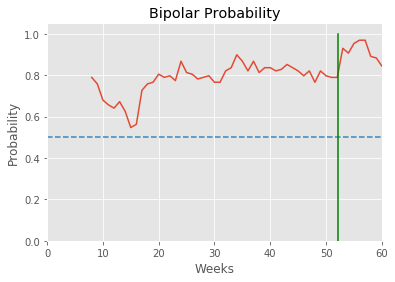

117
dcgerald
2013-07-20 00:00:00
2013-07-24 00:59:31
2013-09-17 08:55:29


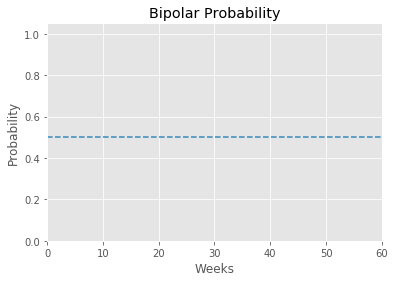

118
josephcott
2015-12-04 00:00:00
2014-12-03 16:11:25
2016-03-04 02:09:42


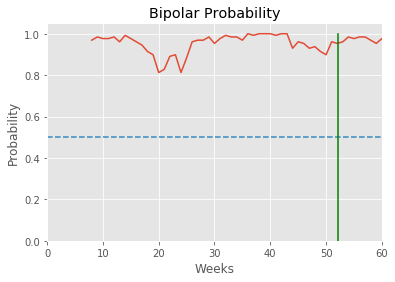

119
BaumG76
2016-05-12 00:00:00
2016-03-08 23:31:43
2016-08-04 11:15:26


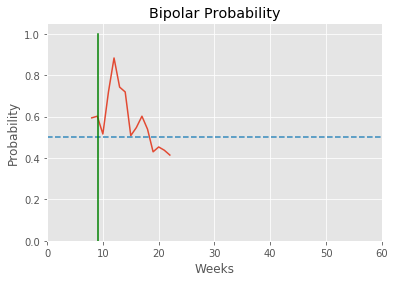

120
nidhighe
2013-05-29 00:00:00
2012-05-28 22:47:48
2013-08-29 09:07:21


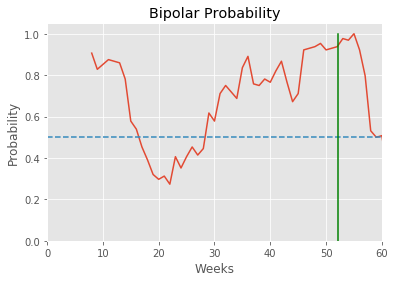

121
yohaw
2013-05-18 00:00:00
2012-05-01 00:33:39
2013-08-01 14:56:09


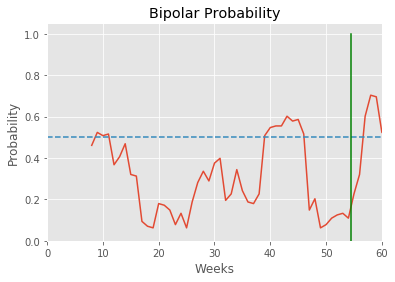

122
Luucekay
2017-01-16 00:00:00
2016-01-16 23:34:20
2017-02-06 18:41:38


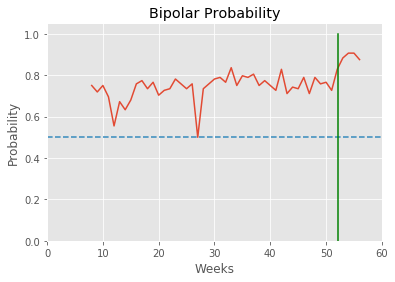

123
DeeJane7
2015-05-01 00:00:00
2014-05-05 23:45:28
2015-07-28 20:06:28


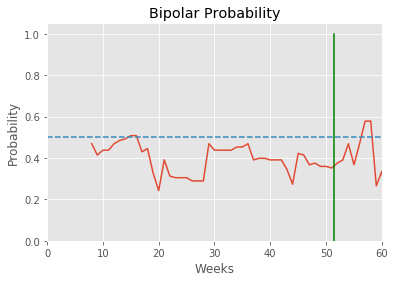

124
benjohnsick
2016-05-05 00:00:00
2015-05-07 15:35:49
2016-08-04 20:20:13


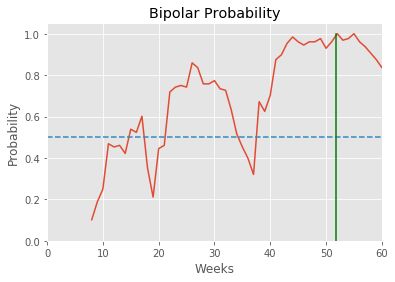

125
ObiWanChloe
2014-07-15 00:00:00
2013-07-15 02:18:09
2014-10-05 20:26:35


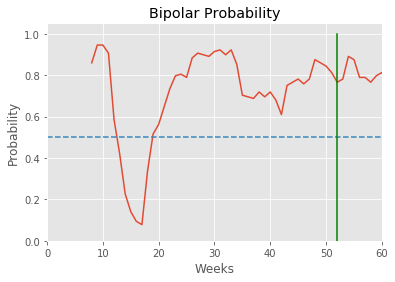

126
Empromancy
2015-01-01 00:00:00
2014-03-02 23:46:30
2015-01-15 18:47:06
127
lexeme
2015-06-12 00:00:00
2014-06-11 18:01:39
2015-09-12 14:11:47


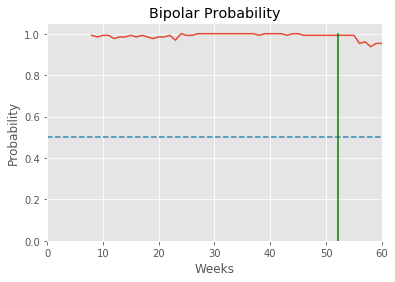

128
CamWillReadu
2015-05-25 00:00:00
2014-05-24 16:17:09
2015-08-25 15:33:42


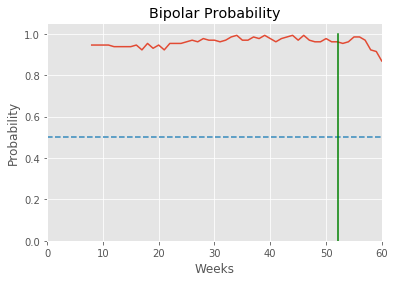

129
mikayla_radich
2014-01-01 00:00:00
2012-12-31 23:45:27
2014-04-01 05:07:28


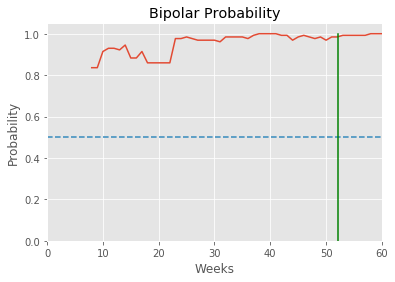

130
easytide
2014-03-21 00:00:00
2013-03-20 17:51:15
2014-06-21 15:47:29


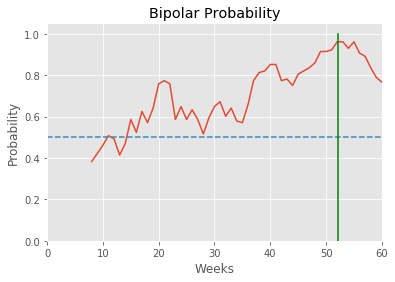

131
TIGN3Y
2016-11-08 00:00:00
2016-08-06 23:08:10
2016-12-29 00:10:03


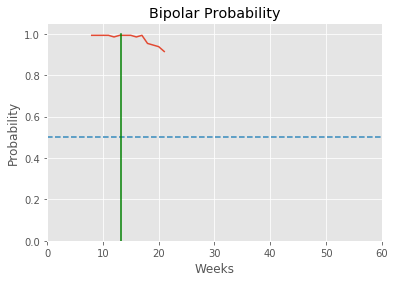

132
bunnyelephant
2016-12-01 00:00:00
2016-06-01 01:08:19
2017-02-06 10:45:06


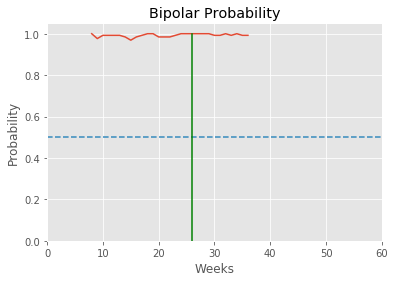

133
jimmypiper2
2013-11-19 00:00:00
2013-02-21 03:34:38
2014-02-19 10:38:42


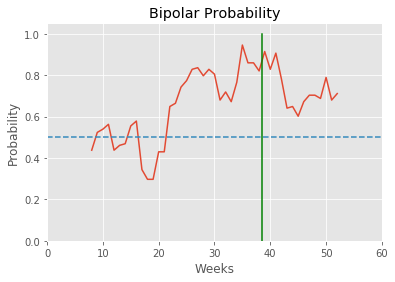

134
FinallyBipolar
2014-04-09 00:00:00
2014-04-24 20:37:17
2014-07-08 21:12:58


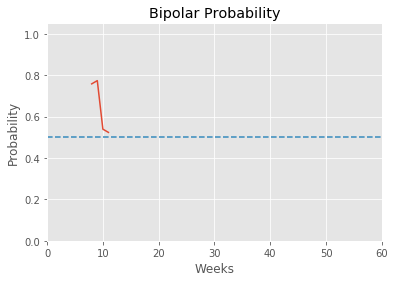

135
girlwtheblade
2012-12-01 00:00:00
2011-12-23 08:38:56
2013-02-24 05:10:17
136
nostaIgicmoons
2013-07-01 00:00:00
2013-04-21 15:36:01
2013-10-01 15:37:58


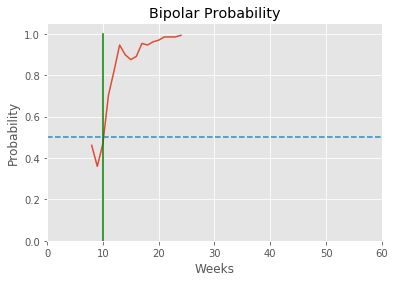

137
kierstingale
2014-01-01 00:00:00
2013-01-01 20:10:10
2014-04-01 02:55:23


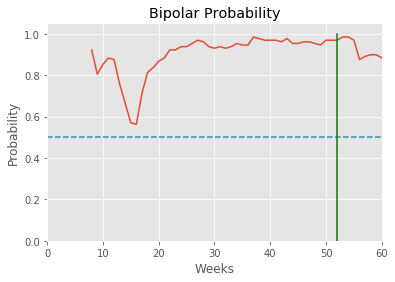

138
Nattyneou
2014-07-06 00:00:00
2013-07-06 16:22:34
2014-10-05 14:54:08


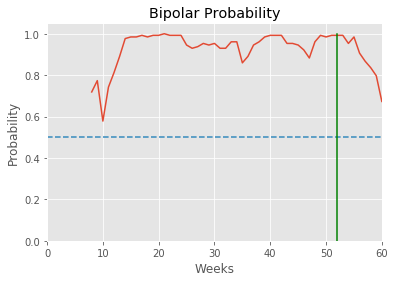

139
_weewee
2015-10-01 00:00:00
2014-09-30 23:56:54
2015-12-06 02:11:54


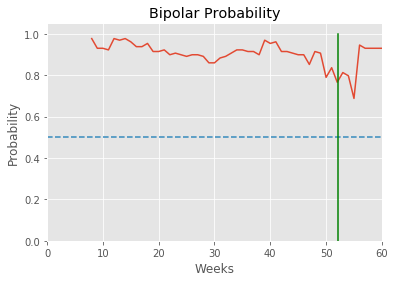

140
creeptrash
2014-11-01 00:00:00
2013-10-31 17:23:00
2015-02-01 10:06:00


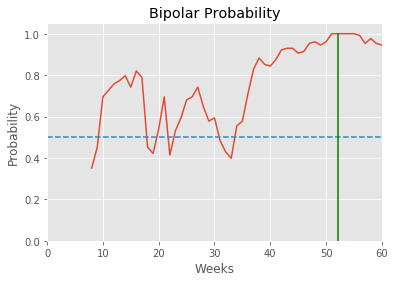

141
AshesAndSnow713
2015-01-15 00:00:00
2014-06-02 15:50:35
2015-04-06 15:14:02


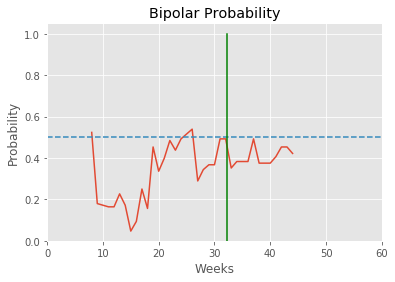

142
bromopoet
2015-07-01 00:00:00
2015-05-21 06:52:21
2015-09-05 05:35:07


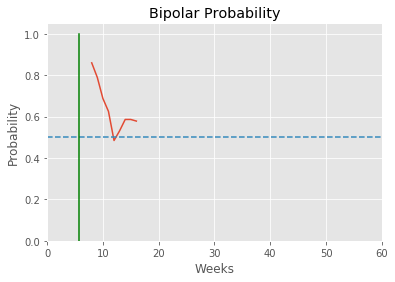

143
_rachelsarahxo
2016-11-15 00:00:00
2015-12-23 11:07:12
2017-02-06 13:56:19
144
edlukethird
2014-04-01 00:00:00
2013-04-03 21:11:31
2013-10-30 23:31:48


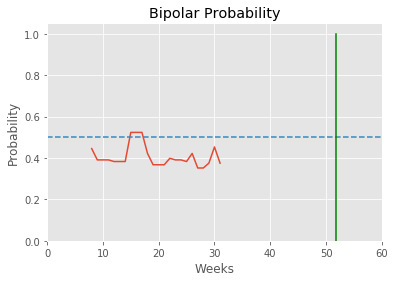

145
sbaestianstan
2015-09-01 00:00:00
2015-08-17 07:49:35
2015-12-01 15:46:43


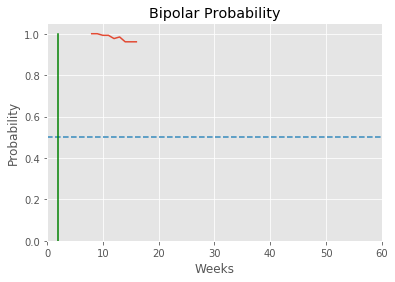

146
DemiLovatic5H
2016-04-08 00:00:00
2015-04-10 19:25:34
2016-07-02 14:30:16


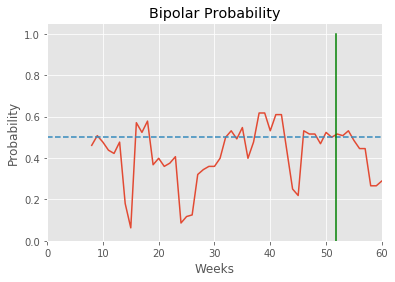

147
BattyBrilliance
2015-11-01 00:00:00
2015-09-07 12:56:15
2016-02-01 13:39:26


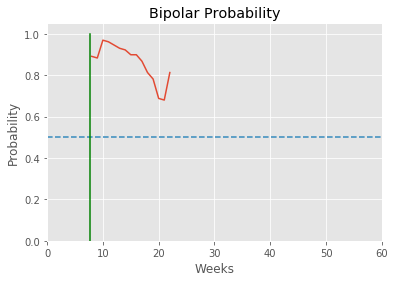

148
clyder1966
2013-10-01 00:00:00
2013-08-20 00:08:53
2013-12-22 23:38:39


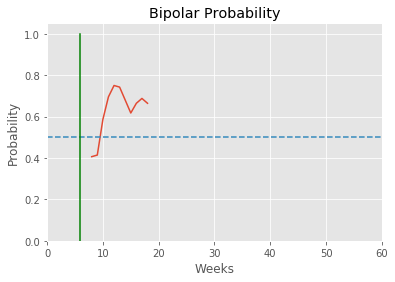

149
LochnessaMarie
2015-01-27 00:00:00
2014-01-31 05:47:14
2015-04-27 15:24:42


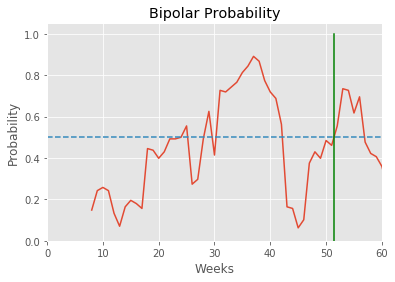

150
shiku___
2016-03-01 00:00:00
2015-03-11 02:58:41
2016-06-01 11:31:56


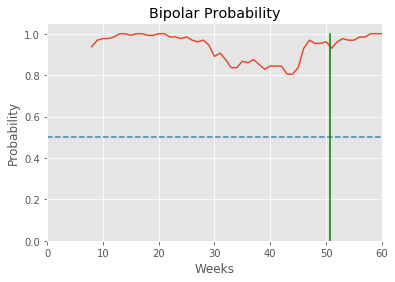

151
_FunSize_QT
2013-04-07 00:00:00
2012-04-06 17:58:20
2013-07-06 18:28:22


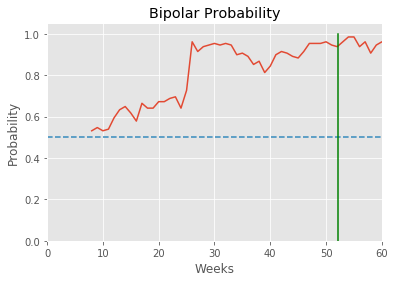

152
StephGambini
2014-04-03 00:00:00
2013-05-21 22:16:50
2014-07-03 05:45:30
153
JillianKarger
2013-08-01 00:00:00
2012-08-02 10:57:59
2013-10-13 12:56:26


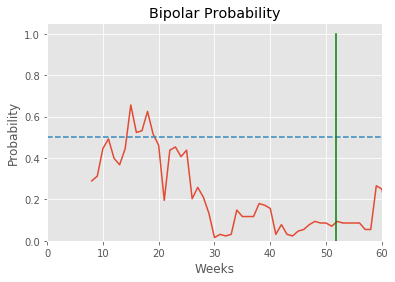

154
snowstormokami
2016-06-30 00:00:00
2016-06-24 03:01:38
2016-09-30 15:33:56


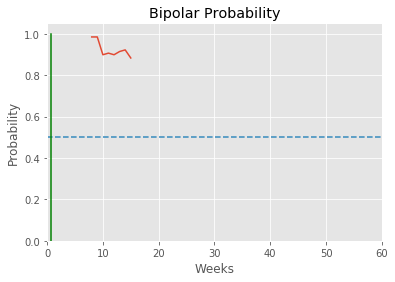

155
cuts4ndsc4rs
2013-04-26 00:00:00
2013-03-11 22:53:47
2013-05-27 19:26:20


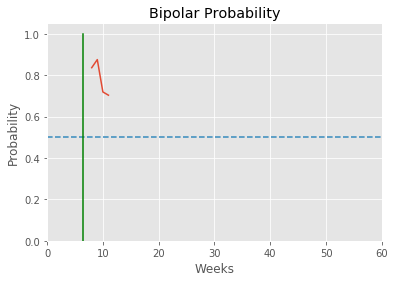

156
TWallaceMusic
2016-01-01 00:00:00
2015-01-25 10:01:21
2016-03-31 20:46:38


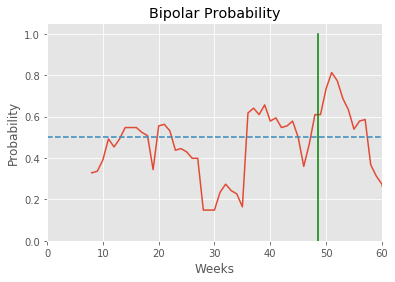

157
whippie3675
2016-01-22 00:00:00
2015-01-23 05:52:40
2016-04-19 15:38:33
158
CelticKaty88
2016-08-01 00:00:00
2015-08-01 01:01:55
2016-11-01 15:50:27


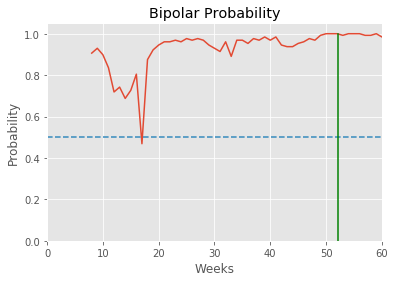

159
YangMummy
2013-01-01 00:00:00
2012-02-05 23:02:15
2013-04-01 11:27:43
160
razorblxde
2013-08-25 00:00:00
2013-01-26 18:26:32
2013-11-24 18:07:41


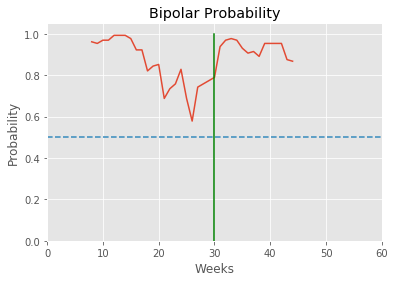

161
eds_shirtsleeve
2013-08-28 00:00:00
2012-08-27 16:02:50
2013-11-28 14:46:03


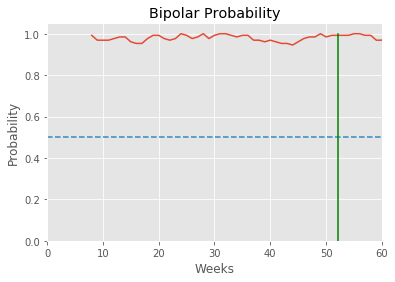

162
ganjasaurusr3x
2013-04-25 00:00:00
2013-03-04 02:58:04
2013-07-25 15:37:36


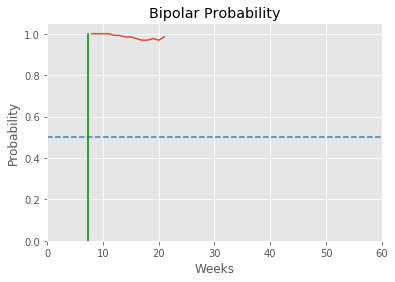

163
horrorvoid
2016-09-10 00:00:00
2015-09-10 19:09:37
2016-12-09 00:09:03


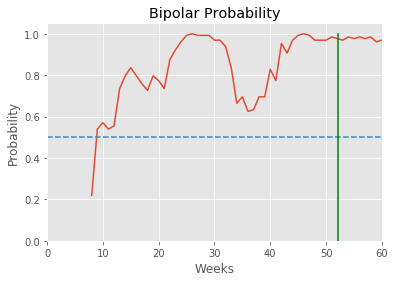

164
allagrugous
2015-06-18 00:00:00
2014-07-18 23:17:04
2015-09-18 15:13:37
165
MeridianRehab
2016-07-06 00:00:00
2015-10-09 21:00:00
2016-10-06 13:30:55


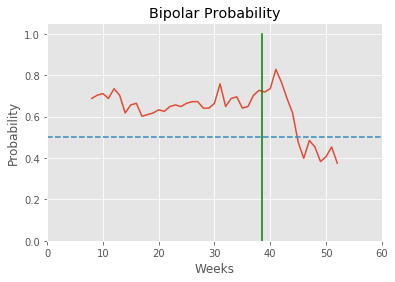

166
Oello12
2013-03-01 00:00:00
2012-03-01 06:38:33
2013-06-01 08:37:00


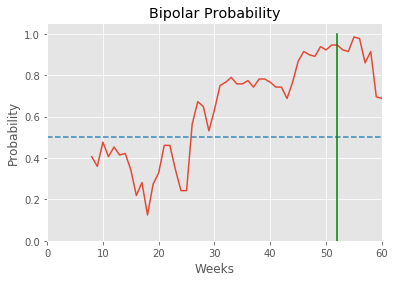

167
enjoyscarlett_
2015-04-03 00:00:00
2014-04-02 16:29:29
2015-07-03 15:28:04


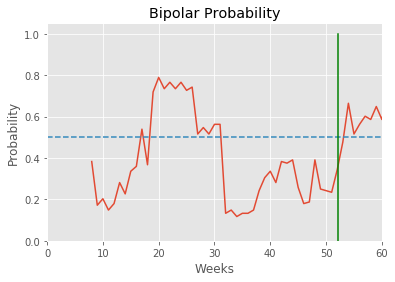

168
recoveryspirit
2014-05-08 00:00:00
2013-05-07 16:00:17
2014-08-08 15:59:07


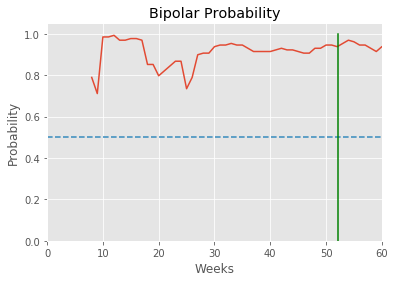

169
mattstreuli
2015-05-22 00:00:00
2014-05-21 18:02:40
2015-08-22 14:05:22


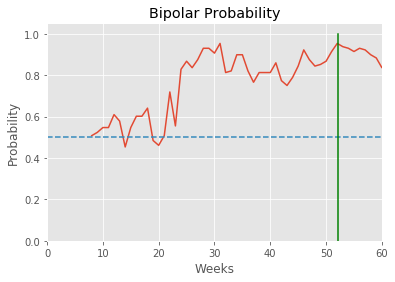

170
TinyLittleChen
2014-10-20 00:00:00
2013-10-19 16:02:43
2015-01-20 10:09:44


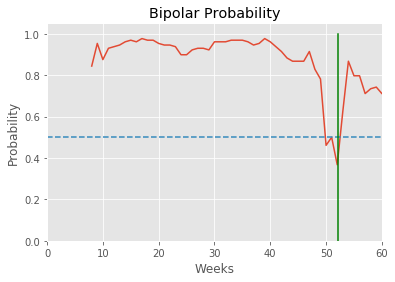

171
Lesism
2014-09-01 00:00:00
2013-08-31 16:04:46
2014-12-01 12:57:00


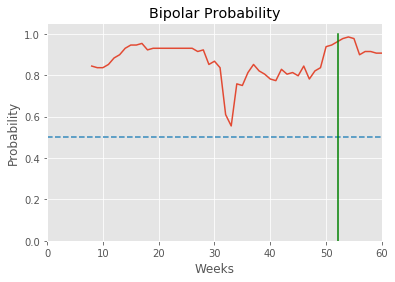

172
TheInsaneIdol
2014-03-01 00:00:00
2013-03-14 21:26:41
2014-05-31 14:36:30


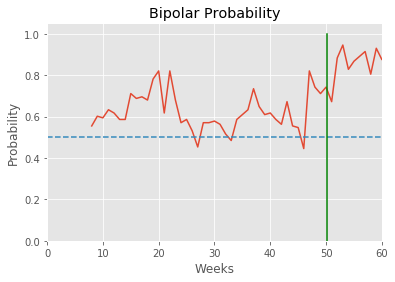

173
Megrrrs
2015-12-09 00:00:00
2014-12-08 16:09:42
2016-03-08 18:01:46


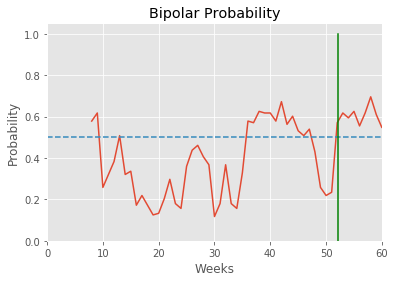

174
_kenziiieee_
2016-03-04 00:00:00
2015-03-06 09:50:05
2016-06-02 15:08:58


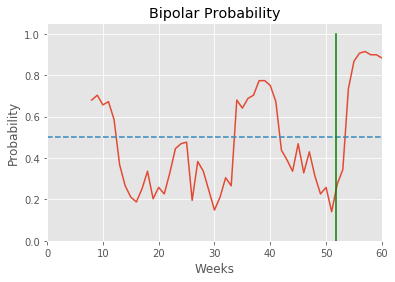

175
hamburgerphone
2016-11-09 00:00:00
2015-11-08 19:54:32
2016-12-28 20:46:47


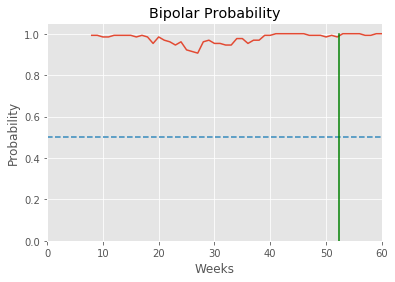

176
__bmorris
2013-04-01 00:00:00
2012-05-21 02:20:35
2013-07-01 08:02:23


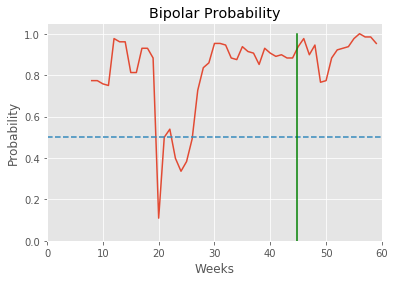

177
Moziee22
2016-07-20 00:00:00
2016-06-02 09:50:03
2016-10-19 06:21:40


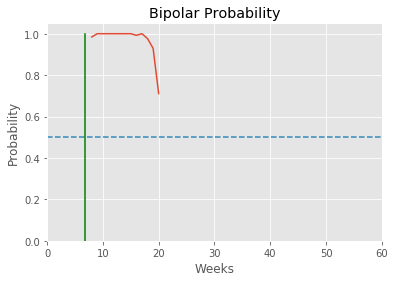

178
LonerBelle
2015-05-21 00:00:00
2014-05-29 07:40:23
2015-07-30 09:44:46


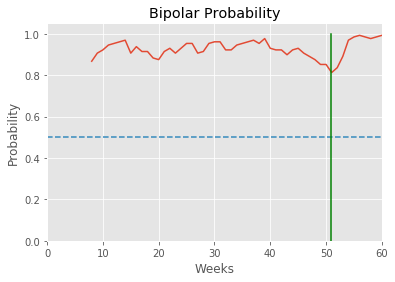

179
BrianCrimson
2014-07-01 00:00:00
2013-06-30 16:13:10
2014-10-01 09:46:35


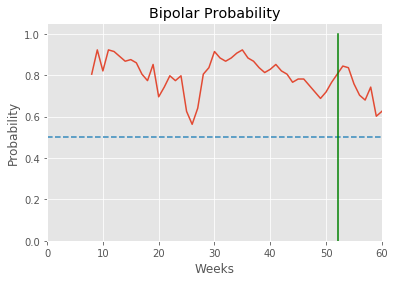

In [79]:
for i, bd_timeline in enumerate(bd_clean):
    print(i)
    print(bd_clean[i]['name'][0])
    print(patient_month_time_dict[bd_clean[i]['name'][0]])
    print(bd_clean[i].index[0])
    print(bd_clean[i].index[-1])
    try:
        predict_prob_list = pol_report(bd_timeline)
        if len(predict_prob_list) < 1 : 
            print('\t No match time')
            continue
        plt.plot(range(len(predict_prob_list)+8)[8:],[window_info['bipolar_probability'] for window_info in predict_prob_list])
        plt.xlabel('Weeks')
        plt.ylabel('Probability')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 60])
        plt.plot((0, 60), (0.5, 0.5), '--')
        plt.title("Bipolar Probability")
        plt.legend(loc="lower right")
        plt.grid(True)
        diagnosed_week = (patient_month_time_dict[bd_clean[i]['name'][0]] - bd_clean[i].index[0]).days / 7.0
        plt.plot((diagnosed_week, diagnosed_week), (0.0, 1.0), 'g-')
        plt.show()
        plt.close()
    except:
        continue

0
NiallBunny
2016-06-20 00:00:00
2016-05-28 11:30:04
2016-09-19 17:06:48


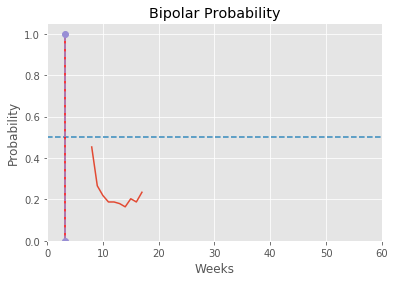

1
zozo_ed
2016-02-01 00:00:00
2015-02-01 02:39:27
2016-05-01 22:00:15


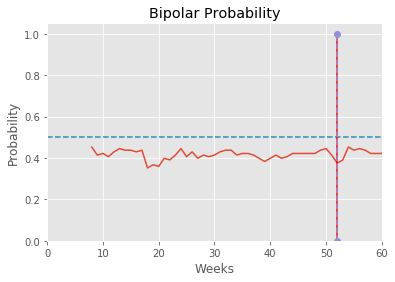

2
yobitchmiranda
2016-12-09 00:00:00
2015-12-09 05:36:43
2017-02-06 11:02:54


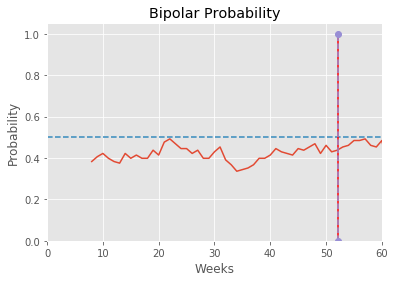

3
_raspberries
2016-03-04 00:00:00
2015-05-22 09:01:11
2016-06-04 13:27:04


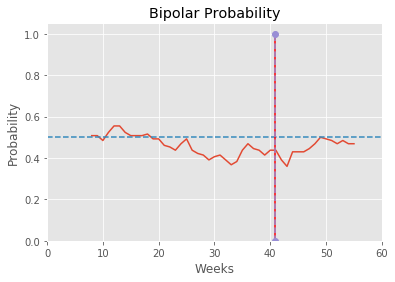

4
sanchezpaige
2013-06-19 00:00:00
2012-06-19 02:42:23
2013-09-19 23:31:05


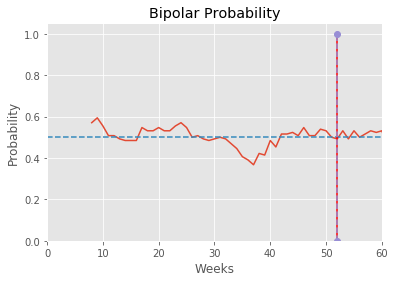

5
C_Leex3
2014-09-19 00:00:00
2014-09-29 14:05:58
2014-12-07 07:54:07


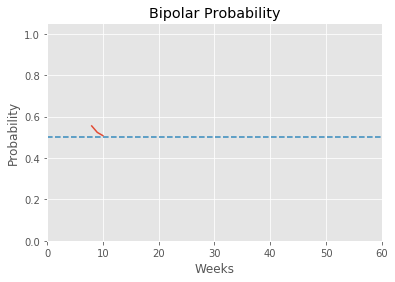

6
silencedrowns
2017-01-16 00:00:00
2016-01-16 03:16:26
2017-02-08 00:11:10
7
fmmshotme
2015-11-01 00:00:00
2015-12-09 15:43:45
2016-02-01 22:20:17


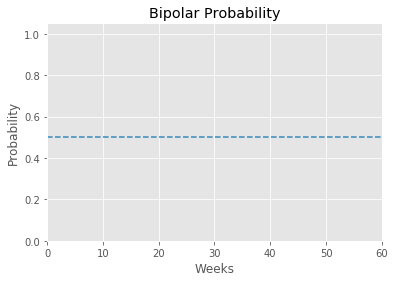

8
MUNTBABY
2014-02-13 00:00:00
2013-02-13 01:49:31
2014-05-13 23:46:41


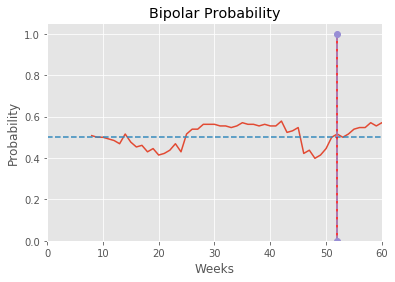

9
TommmMate
2017-01-22 00:00:00
2016-01-22 23:31:36
2017-02-04 01:40:56


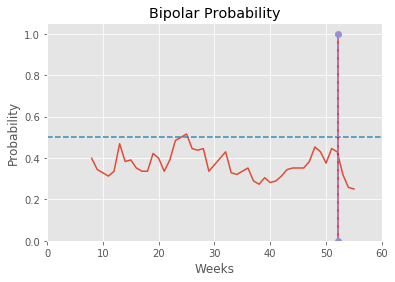

10
X_JuliiiiBabyyy
2015-07-09 00:00:00
2014-07-09 10:57:52
2015-10-09 14:03:58


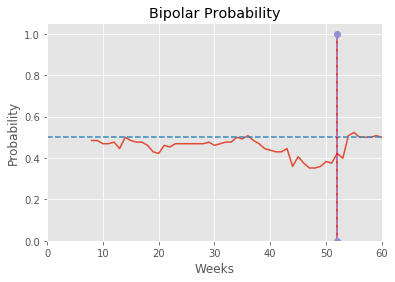

11
nicoletteblando
2015-01-28 00:00:00
2014-01-28 01:17:25
2015-04-07 21:50:21
12
BreSwaGz
2016-06-01 00:00:00
2015-06-17 04:37:35
2016-09-01 22:11:39


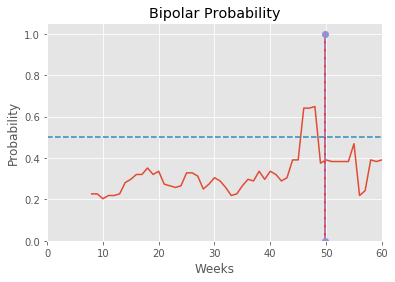

13
rozordie
2013-06-01 00:00:00
2012-06-01 00:00:43
2013-08-31 09:31:05


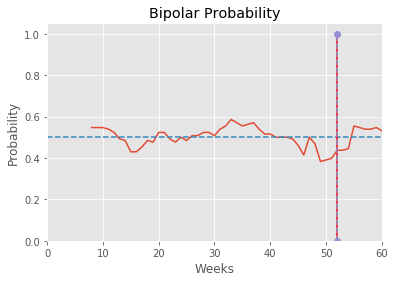

14
killingmyselfpl
2015-01-18 00:00:00
2014-08-04 14:27:04
2015-04-17 14:34:17


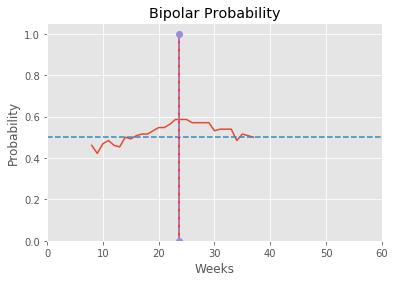

15
verybraveface
2013-12-10 00:00:00
2013-11-20 11:17:36
2014-03-10 23:57:13


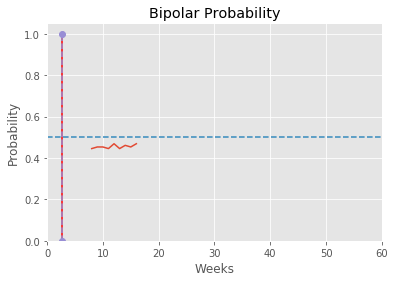

16
right2hell
2017-01-17 00:00:00
2016-12-30 15:54:35
2017-02-07 16:23:50


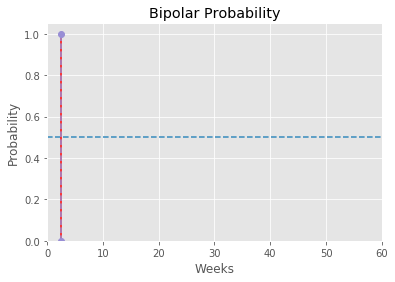

17
aleexturneer_
2014-01-01 00:00:00
2013-01-01 08:02:18
2014-04-01 22:49:39


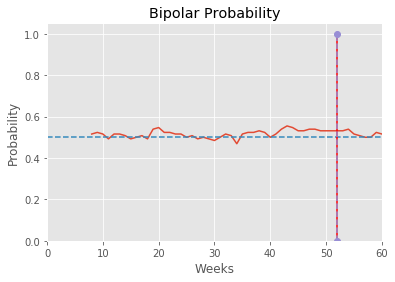

18
ElegantN7
2016-04-20 00:00:00
2015-04-20 15:31:02
2016-07-19 07:45:31
19
PennyCenturyXo
2014-01-28 00:00:00
2013-01-28 22:46:57
2014-04-28 04:28:59


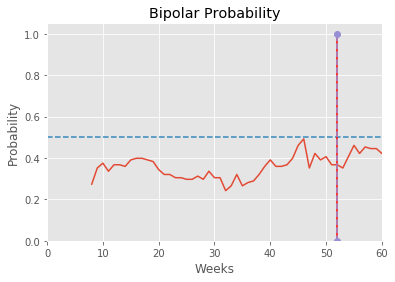

20
PlumBananas
2013-09-01 00:00:00
2012-09-04 22:47:36
2013-11-28 00:20:13


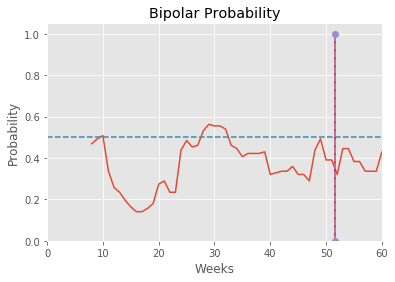

21
AwesomeAsh
2017-01-19 00:00:00
2016-01-22 14:18:02
2017-02-05 05:45:56


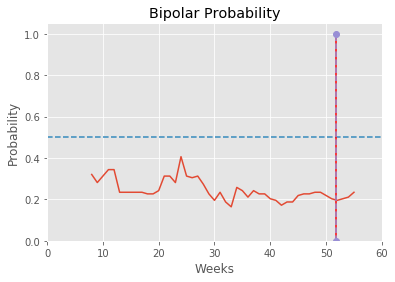

22
matthewRvincent
2017-01-21 00:00:00
2016-01-21 02:22:06
2017-02-06 02:41:37


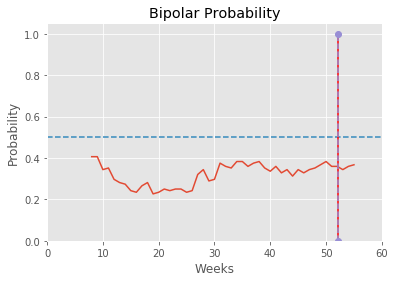

23
TionSavageee
2014-03-01 00:00:00
2013-03-01 01:03:26
2014-06-01 21:12:44


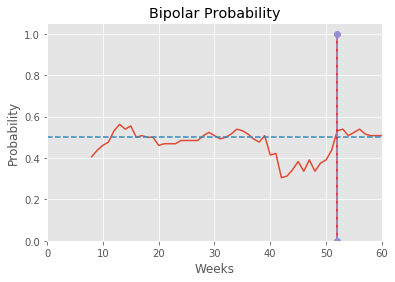

24
io_superare
2015-11-01 00:00:00
2015-12-31 03:11:09
2016-01-29 13:25:20


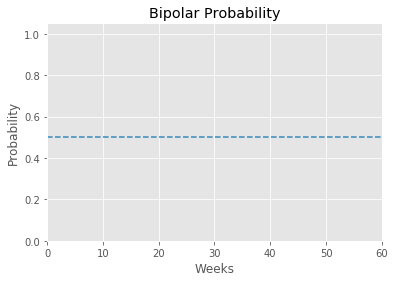

25
reportzoIo
2014-01-01 00:00:00
2013-01-01 08:09:14
2014-04-01 23:59:30


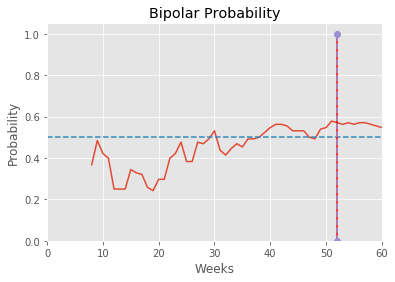

26
Erin_Louisee
2013-09-01 00:00:00
2012-09-01 04:12:29
2013-12-01 13:08:55


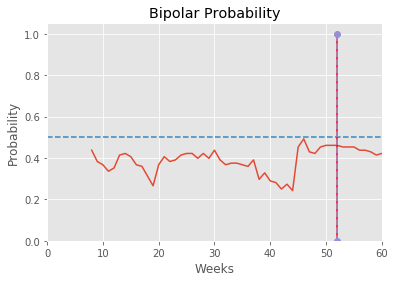

27
Jennys67
2014-02-06 00:00:00
2013-06-05 04:50:03
2014-05-04 11:47:21


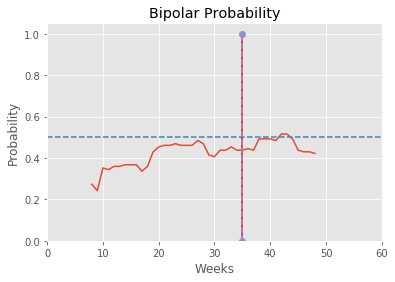

28
Vixoen
2013-06-01 00:00:00
2012-06-01 00:31:21
2013-09-01 15:28:50


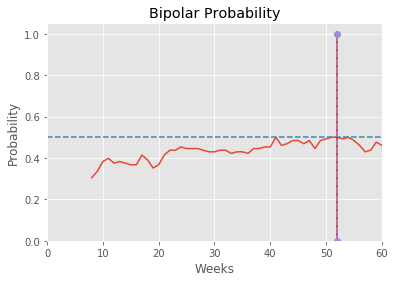

29
PunkRockHappy
2013-10-22 00:00:00
2012-10-24 07:55:05
2014-01-22 11:05:57


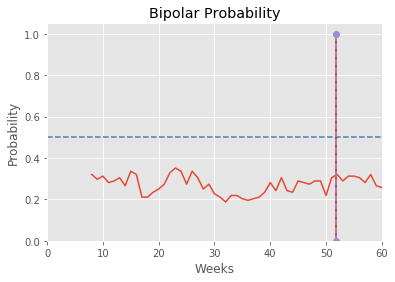

30
kakes_bakes
2012-09-01 00:00:00
2011-09-13 02:29:33
2012-11-21 10:07:38
31
complicatedcon
2017-01-11 00:00:00
2016-08-04 05:51:36
2017-02-06 14:58:50


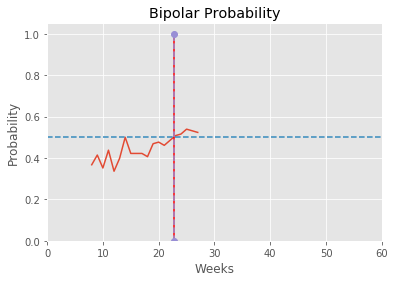

32
missmyerz9123
2015-12-18 00:00:00
2015-01-02 23:31:49
2016-03-17 23:44:27


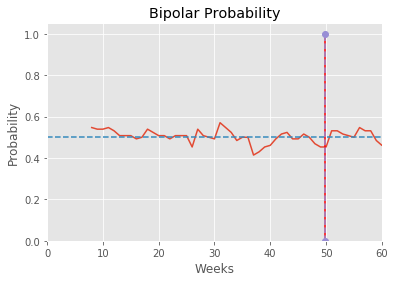

33
blue_moon_witch
2013-12-01 00:00:00
2014-01-22 02:14:28
2014-02-25 00:48:19


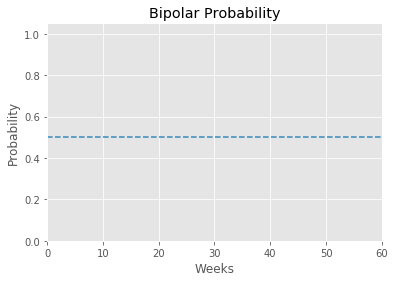

34
ValeourM
2013-09-01 00:00:00
2012-09-01 00:11:32
2013-12-01 16:06:27


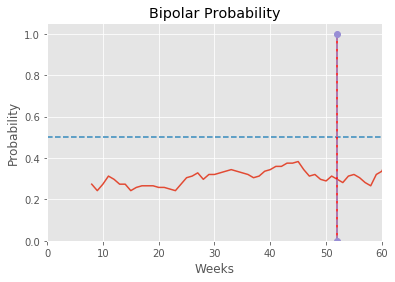

35
KashawnTaylor
2015-01-13 00:00:00
2014-01-13 01:06:45
2015-04-10 18:07:07


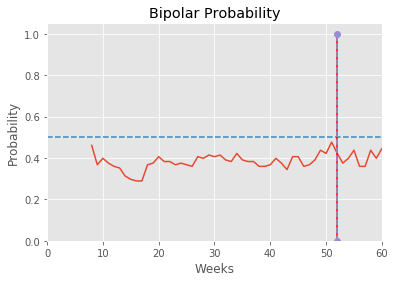

36
Ma7mood101
2014-06-19 00:00:00
2013-06-19 16:00:35
2014-09-17 20:10:16


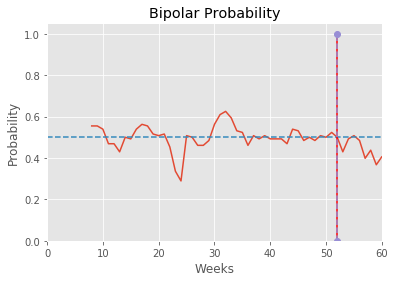

37
Boricua611
2015-08-01 00:00:00
2014-09-26 22:18:20
2015-11-01 11:18:12


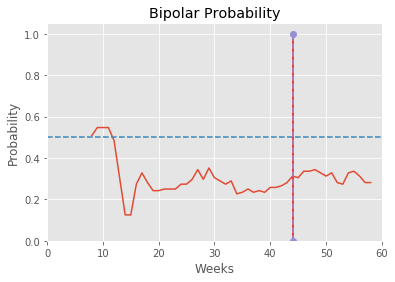

38
ddlovatoanangel
2013-09-17 00:00:00
2012-09-17 08:22:01
2013-12-16 17:03:58


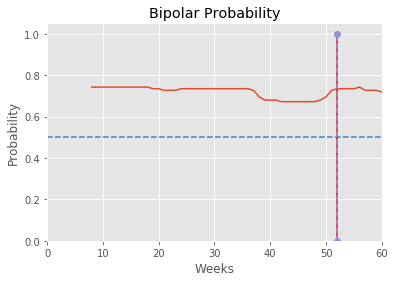

39
ChantyRomard
2016-10-16 00:00:00
2015-10-16 00:30:53
2016-12-22 21:26:24


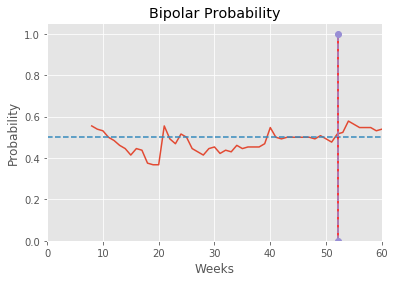

40
lil_miss_caf
2014-08-15 00:00:00
2013-08-15 00:00:57
2014-11-15 23:40:51


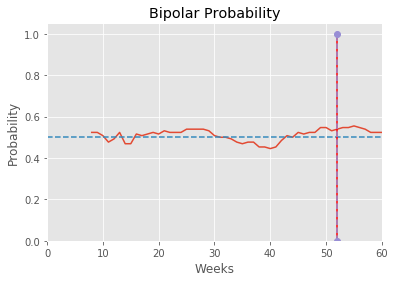

41
musicaIhoe
2016-01-27 00:00:00
2015-09-27 08:09:59
2016-04-22 13:49:48


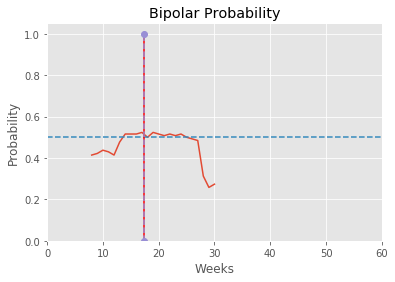

42
Scooby_Who
2012-10-01 00:00:00
2011-10-01 01:03:54
2013-01-01 23:42:54


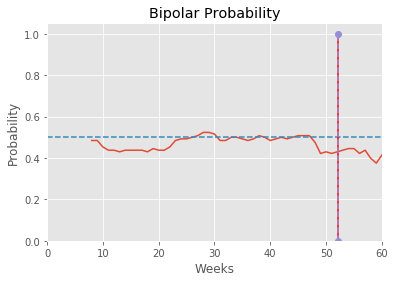

43
p_rapper
2013-02-01 00:00:00
2012-02-04 22:03:49
2013-04-04 14:50:39
44
dogcalledbambi
2014-06-18 00:00:00
2013-06-18 01:46:22
2014-09-18 06:04:14


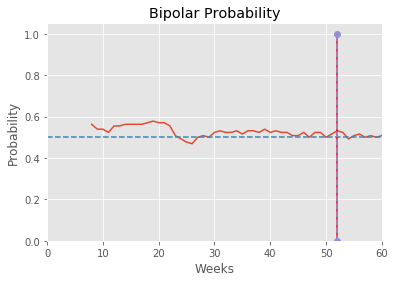

45
NeliaCarolyn
2013-11-14 00:00:00
2012-11-14 01:29:24
2014-02-14 23:46:17


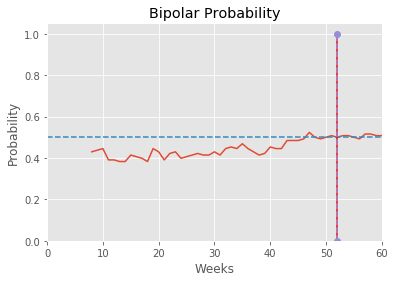

46
coolfamilyblog
2015-08-26 00:00:00
2014-08-27 11:34:51
2015-11-23 11:13:18


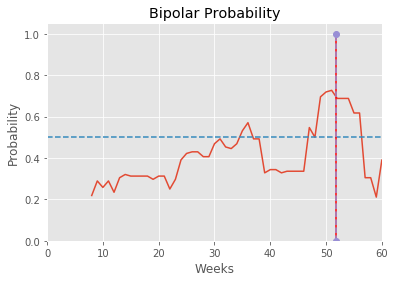

47
darrenleewelsh
2015-02-08 00:00:00
2014-05-11 11:43:56
2015-04-16 21:10:58
48
musicandincense
2014-12-04 00:00:00
2014-10-10 12:59:18
2015-02-16 21:31:35


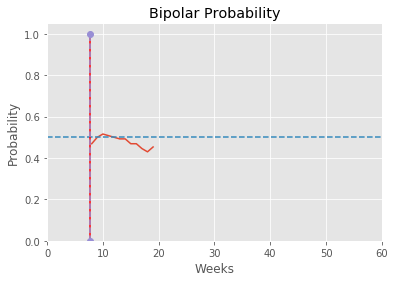

49
kawaiicutforth
2014-09-25 00:00:00
2014-08-05 09:35:17
2014-12-25 23:38:57


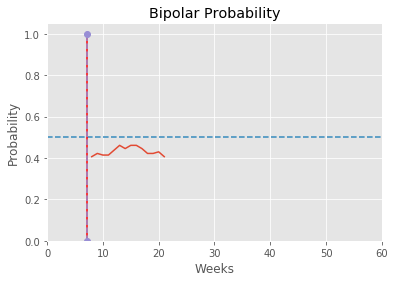

50
obliviousm3
2014-10-01 00:00:00
2014-06-17 03:18:12
2015-01-01 08:49:55


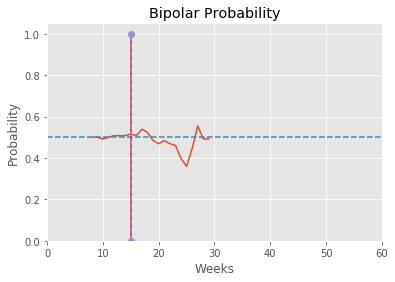

51
Lesh_taboo
2016-01-01 00:00:00
2015-01-03 11:30:32
2016-04-01 20:36:37


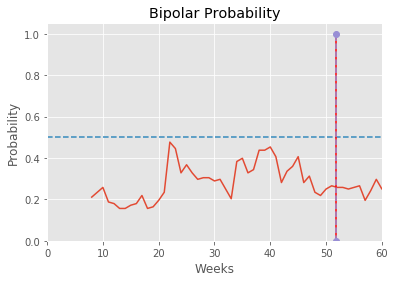

52
chucho109031995
2015-09-01 00:00:00
2015-05-04 11:21:27
2015-07-28 07:52:06


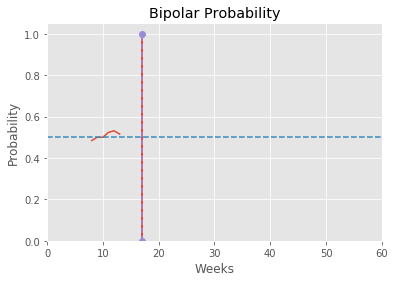

53
GeraintWaddon
2014-07-04 00:00:00
2013-07-04 14:50:17
2014-10-04 13:15:25


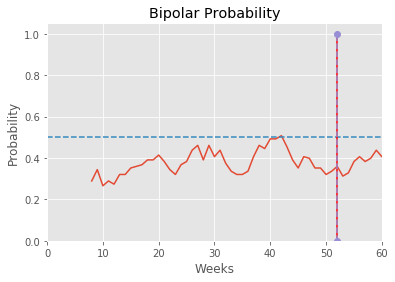

54
SammyFucknFenty
2015-04-01 00:00:00
2014-04-01 23:34:28
2015-07-01 22:48:13


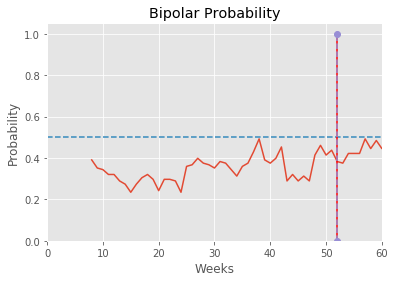

55
f0reverliving
2017-01-19 00:00:00
2016-01-21 01:27:04
2017-02-06 20:02:23


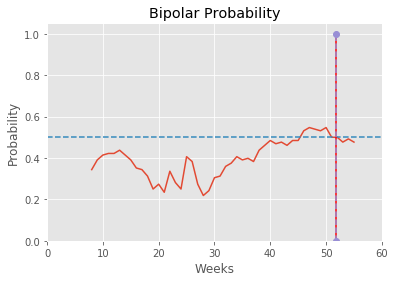

56
TheBornDreamer
2013-06-01 00:00:00
2012-06-02 07:53:11
2013-09-01 21:15:24


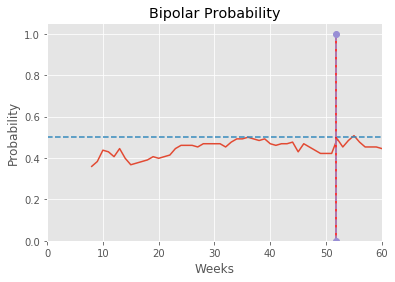

57
DatShitKrae
2015-11-13 00:00:00
2015-03-06 01:08:40
2016-02-13 00:06:36


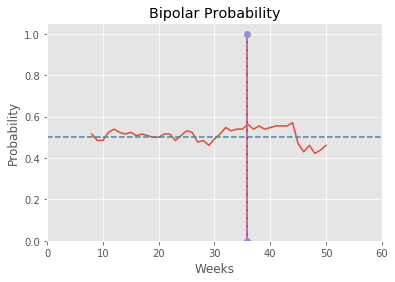

58
delaney_ashlyn
2014-06-20 00:00:00
2013-07-02 00:07:05
2014-09-20 20:58:22


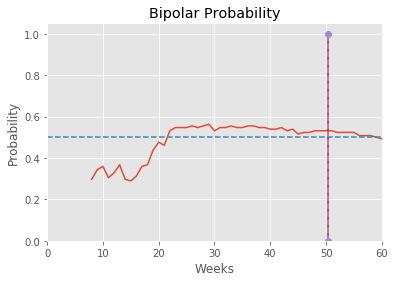

59
BossHossMOB
2016-08-03 00:00:00
2016-07-17 10:17:56
2016-11-03 22:41:01


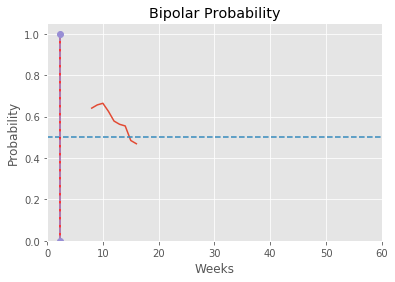

60
KARLXCARL
2015-03-01 00:00:00
2014-03-01 00:38:30
2015-06-01 23:10:40


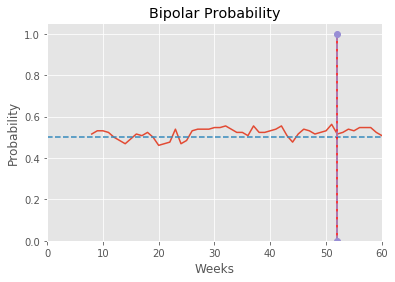

61
CassandraBurns7
2013-01-01 00:00:00
2012-09-28 03:36:41
2013-04-01 23:31:25


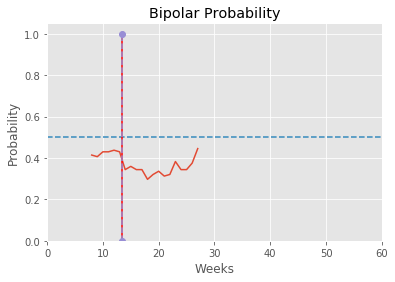

62
ArtistSomeday
2014-01-01 00:00:00
2013-01-20 09:58:26
2013-07-30 12:48:58
63
day0ldhat3
2015-04-07 00:00:00
2014-04-07 10:45:15
2015-07-07 17:49:19


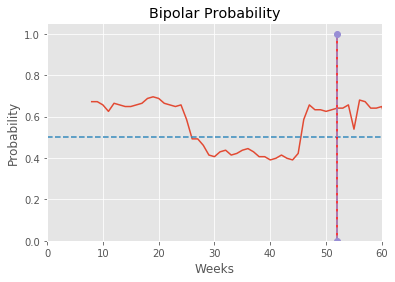

64
CMBogan
2016-02-18 00:00:00
2015-02-18 02:36:28
2016-05-09 03:23:23


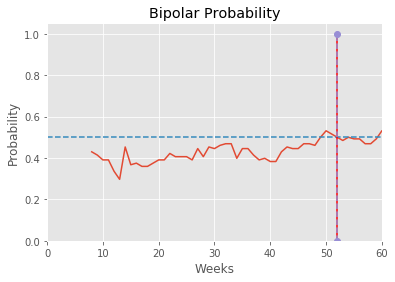

65
Radica_XO_Khidd
2014-11-13 00:00:00
2013-11-16 01:24:10
2015-02-12 03:53:25


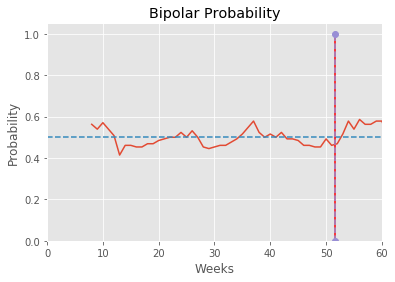

66
graham_bryan
2013-12-01 00:00:00
2013-04-14 00:49:40
2013-08-10 19:00:13
67
Dream_Star_
2013-04-01 00:00:00
2012-04-01 04:52:40
2013-07-01 20:09:59


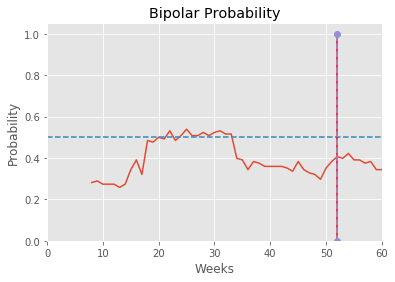

68
oldpaths_pub
2016-07-01 00:00:00
2016-04-11 00:13:01
2016-07-08 22:17:28


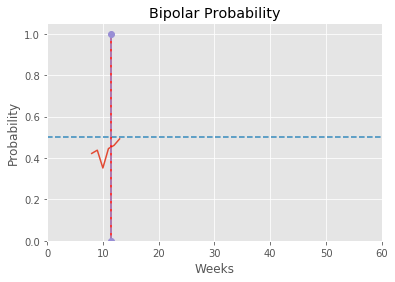

69
spencerncrane
2012-10-30 00:00:00
2012-01-15 06:36:29
2013-01-30 23:26:55


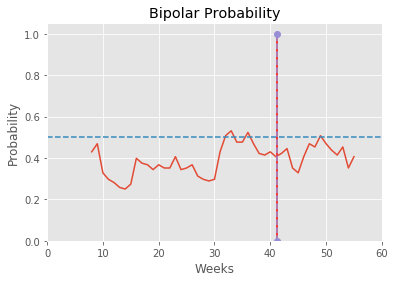

70
kuwabaras_
2016-10-25 00:00:00
2015-10-25 00:00:07
2016-12-29 11:51:37


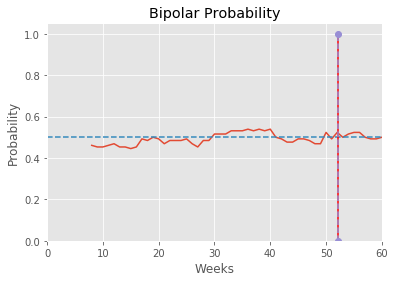

71
ninsnoopy
2014-08-15 00:00:00
2014-06-20 14:17:44
2014-11-15 14:06:43


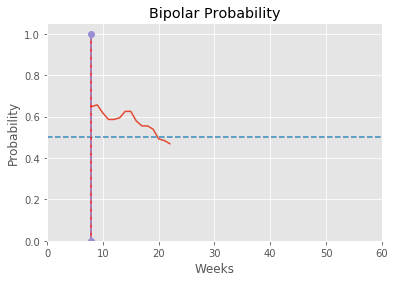

72
laurjbrown
2014-11-15 00:00:00
2013-12-09 13:29:02
2015-02-15 23:45:25


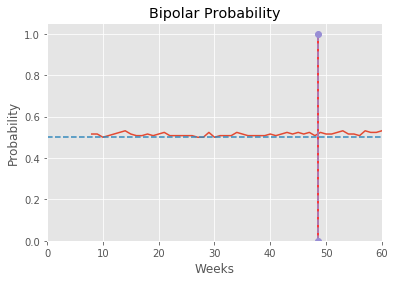

73
sammiethenami
2013-02-01 00:00:00
2012-08-28 20:29:58
2013-03-12 14:42:55
74
TylerCSmith815
2015-09-30 00:00:00
2014-10-30 23:28:48
2015-12-07 21:21:41
75
ceceliaa_
2013-08-01 00:00:00
2012-08-01 00:30:27
2013-10-14 15:12:06


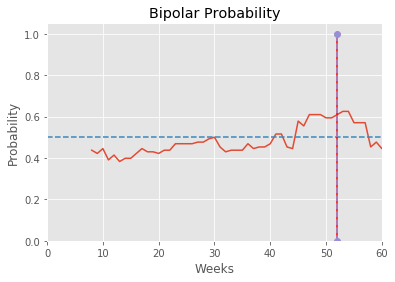

76
rosekelleher4
2016-01-27 00:00:00
2015-01-27 01:25:07
2016-04-27 09:16:25


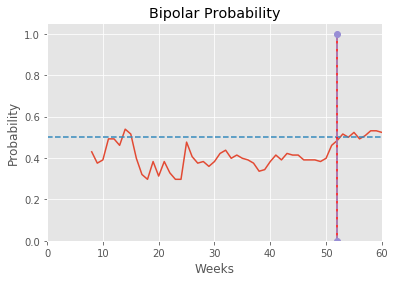

77
HeyThereJohana
2014-10-17 00:00:00
2013-10-17 09:24:22
2015-01-17 21:11:11


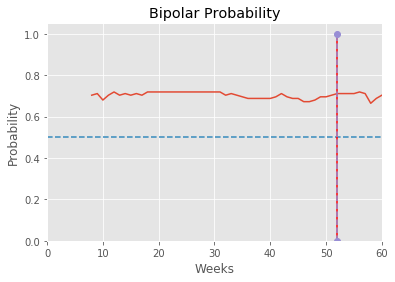

78
inaseaofemotion
2017-01-08 00:00:00
2016-09-15 03:42:05
2017-02-05 12:39:09


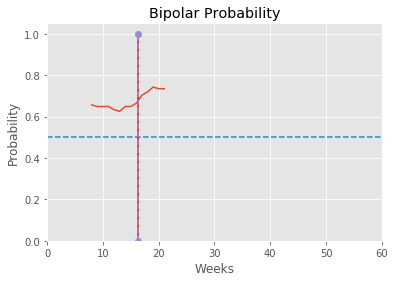

79
ActualJoykiller
2013-01-19 00:00:00
2012-01-20 07:10:11
2013-04-19 14:32:10


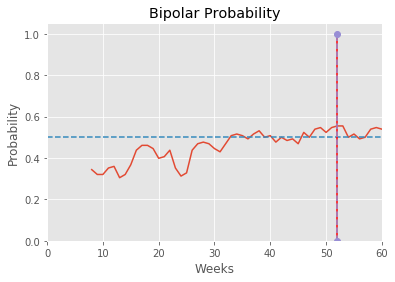

80
4lilpretentious
2017-01-12 00:00:00
2016-03-30 08:23:18
2017-02-08 06:26:24


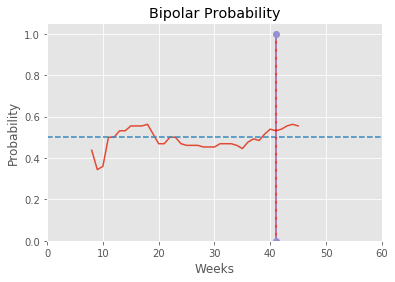

81
jgquinton
2013-10-03 00:00:00
2012-10-03 01:19:32
2014-01-03 14:01:29


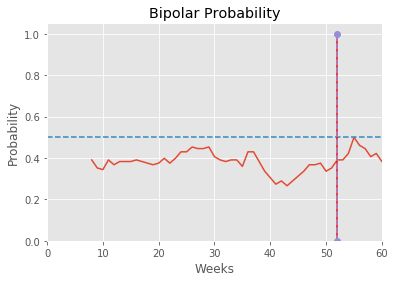

82
JonnyZombi
2016-03-07 00:00:00
2015-03-07 00:26:13
2016-06-07 11:11:19


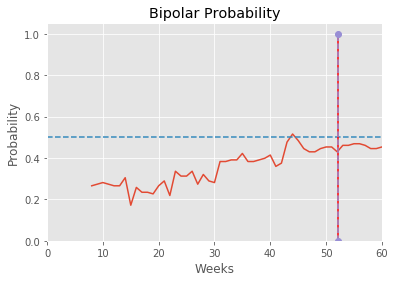

83
waxchinadoll
2015-07-01 00:00:00
2014-07-16 08:44:25
2015-10-01 09:27:32


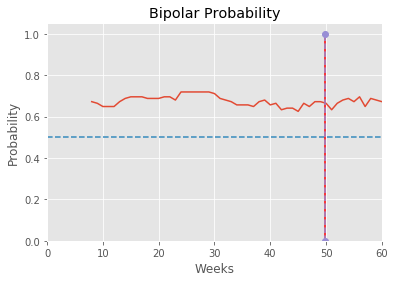

84
Karen_e_miller
2015-05-07 00:00:00
2014-05-07 07:08:31
2015-08-07 12:26:29


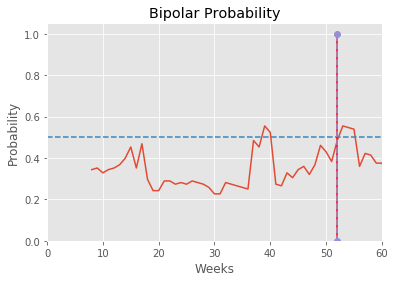

85
_KatKennedy
2014-03-01 00:00:00
2013-03-01 00:06:30
2014-06-01 12:40:21


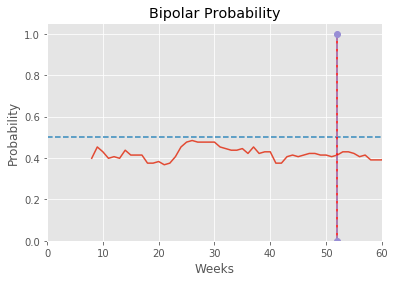

86
jamieboiss
2012-10-01 00:00:00
2011-10-12 05:55:51
2012-12-31 06:05:05


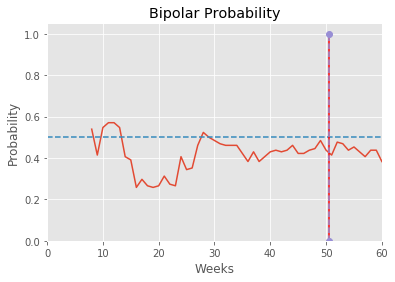

87
LithChronicles
2012-10-01 00:00:00
2012-04-03 04:35:53
2012-05-26 09:02:56


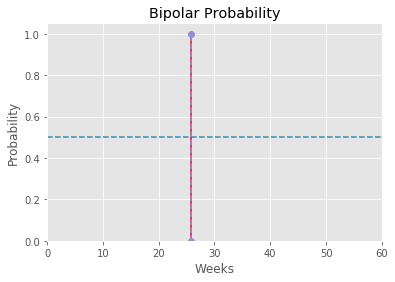

88
Popatrace_OrNah
2014-06-25 00:00:00
2013-06-25 14:33:52
2014-09-25 15:05:57


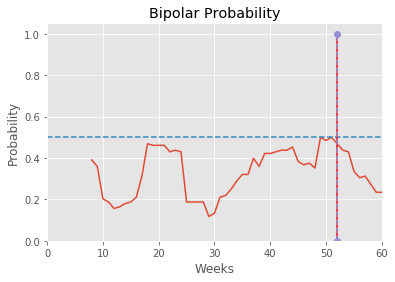

89
colinfarrelfan
2017-01-18 00:00:00
2016-01-18 12:57:11
2017-02-07 17:10:51


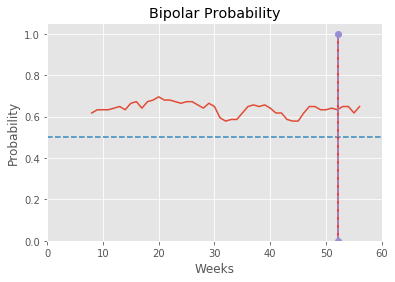

90
kristacathleen1
2015-06-01 00:00:00
2014-09-24 19:42:16
2015-08-04 09:58:01


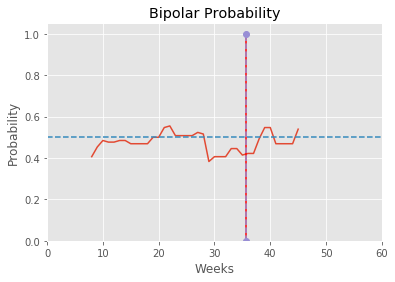

91
mcdoneugh
2015-07-20 00:00:00
2014-07-20 00:08:39
2015-10-18 00:33:03


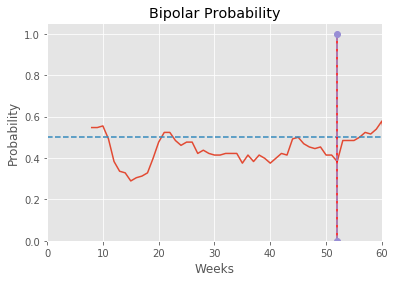

92
PinkBerryShake
2013-03-01 00:00:00
2012-03-01 01:36:52
2012-12-20 15:59:14


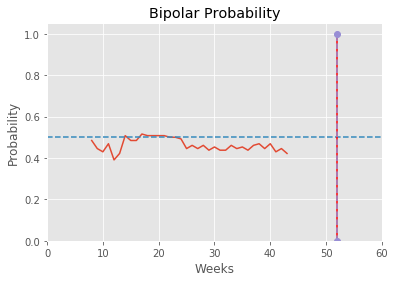

93
dave_ghost
2015-04-11 00:00:00
2014-05-28 08:52:08
2015-07-11 15:15:14


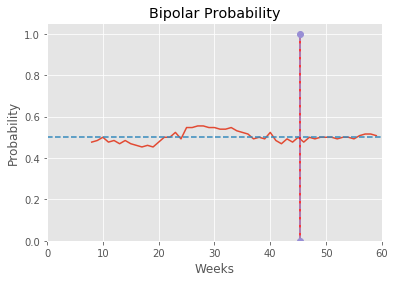

94
KissMyVibe
2013-08-01 00:00:00
2013-07-29 09:58:44
2013-10-26 09:48:14


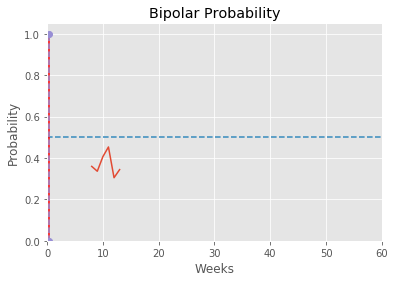

95
TammiJ1973
2012-09-11 00:00:00
2012-10-07 20:50:43
2012-12-11 23:44:06


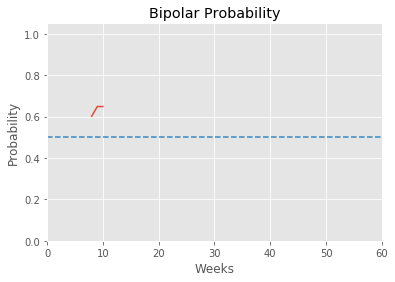

96
celineherbez
2012-02-01 00:00:00
2011-09-04 10:24:04
2012-05-01 18:44:37


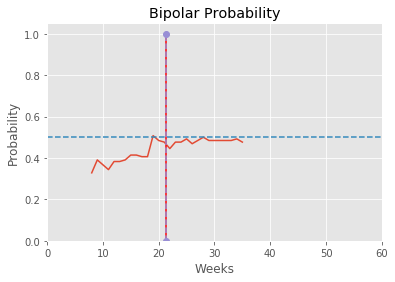

97
GingeKnievil
2014-12-02 00:00:00
2013-12-02 01:14:48
2015-03-02 23:23:42


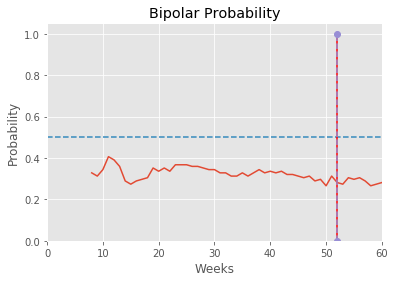

98
fadeaway94
2016-03-01 00:00:00
2015-10-25 23:12:25
2016-03-13 00:13:45
99
Alc43my
2016-11-09 00:00:00
2015-11-24 13:09:05
2016-12-28 05:51:16
100
2lookforward2
2015-09-23 00:00:00
2015-09-04 09:48:08
2015-12-06 08:56:53


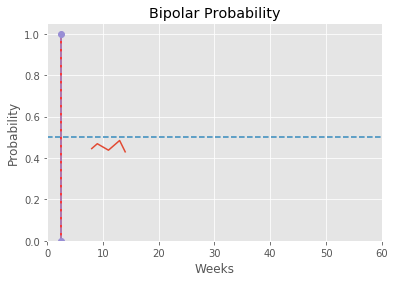

101
AndrewHoughton8
2013-12-20 00:00:00
2013-01-06 15:19:00
2014-03-19 02:12:13


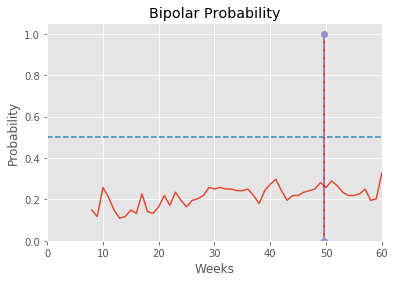

102
Cat_Fowl
2013-03-01 00:00:00
2012-03-01 07:47:52
2013-06-01 07:08:04


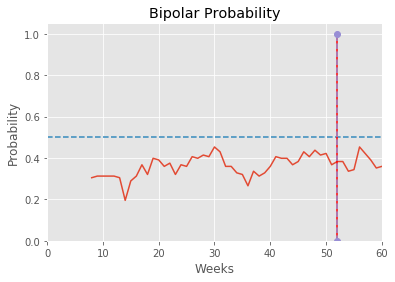

103
Demetria_Wife
2014-06-21 00:00:00
2013-06-21 00:21:34
2014-09-21 21:05:12


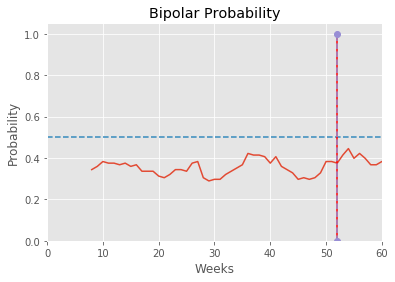

104
SassyPharmD
2014-11-10 00:00:00
2013-11-12 15:30:03
2015-02-10 21:54:59


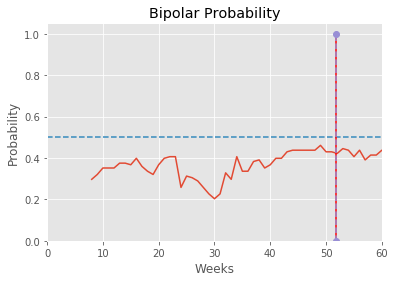

105
LostKaiyna
2014-12-01 00:00:00
2013-12-01 00:53:25
2015-02-28 03:59:28


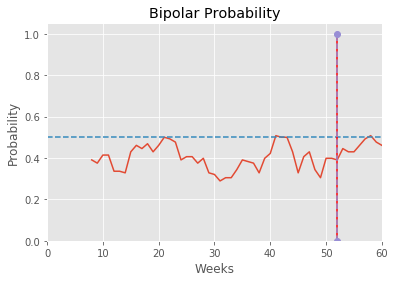

106
ashliewaters
2015-09-19 00:00:00
2014-09-21 15:35:40
2015-12-17 14:42:58


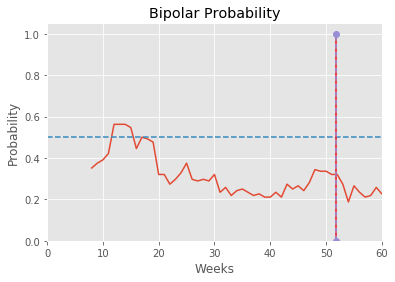

107
jxlsia
2012-08-04 00:00:00
2011-08-23 16:00:38
2012-11-04 21:50:38


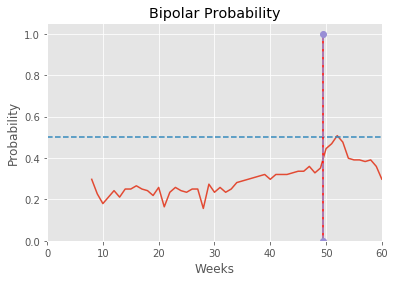

108
ghostofclifford
2016-05-15 00:00:00
2015-09-09 17:21:24
2016-08-15 22:30:25


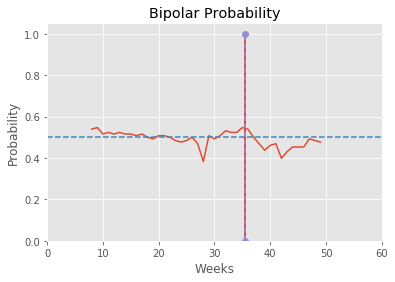

109
philomathspirit
2016-05-25 00:00:00
2015-05-25 01:38:25
2016-08-25 10:29:24


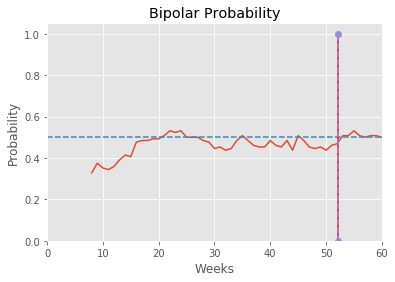

110
rorysxlogan
2015-04-02 00:00:00
2014-04-02 12:01:09
2015-07-02 14:08:25


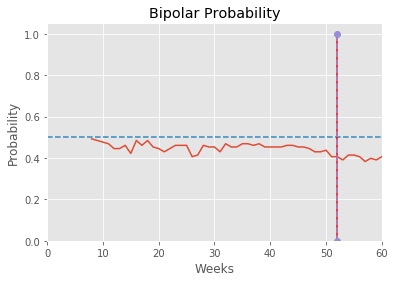

111
b_bylynn
2012-12-01 00:00:00
2012-10-02 03:59:43
2013-03-01 06:16:18


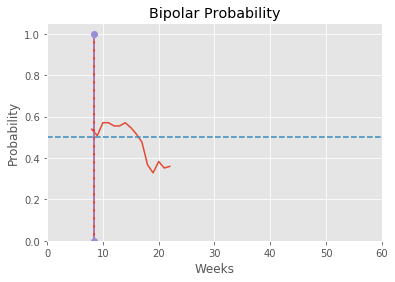

112
Ritz_Tweeting
2014-11-01 00:00:00
2013-11-01 00:48:16
2015-02-01 17:19:55


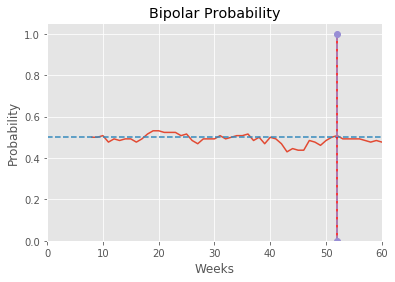

113
CourtneyDePatz
2016-11-11 00:00:00
2015-12-28 05:43:33
2016-12-28 14:09:00


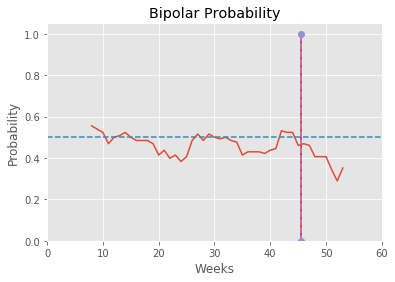

114
k3lvy_
2015-03-01 00:00:00
2014-03-01 04:39:05
2015-06-01 21:53:46


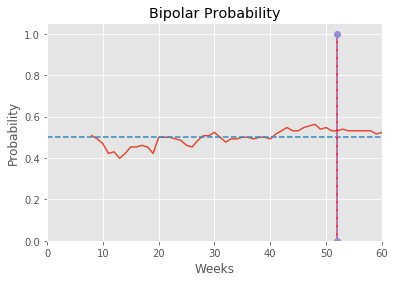

115
thesocialite85
2015-12-01 00:00:00
2015-10-19 19:51:03
2016-02-25 03:03:46


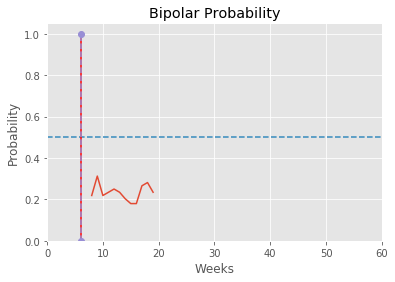

116
Leah_Pupzz
2014-10-01 00:00:00
2014-06-24 17:08:11
2015-01-01 16:54:59


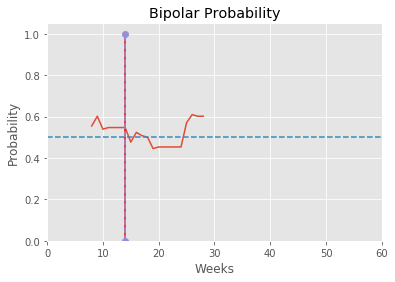

117
Beardy_Mc_Beard
2014-10-20 00:00:00
2013-10-21 12:48:07
2015-01-20 23:49:37
118
matea_friend
2014-04-07 00:00:00
2013-04-07 07:49:52
2014-07-06 17:42:20


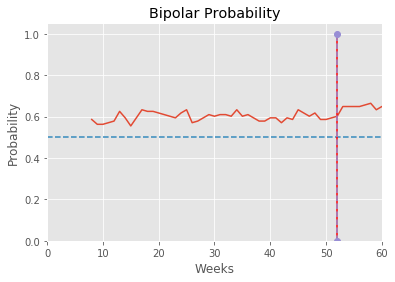

119
dcgerald
2013-07-20 00:00:00
2013-07-24 08:59:31
2013-09-17 16:55:29


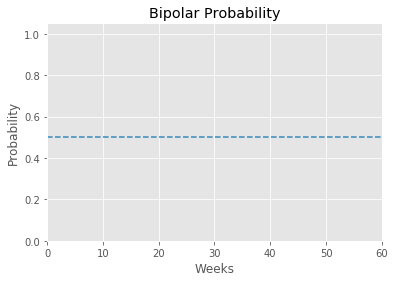

120
josephcott
2015-12-04 00:00:00
2014-12-04 00:11:25
2016-03-04 10:09:42


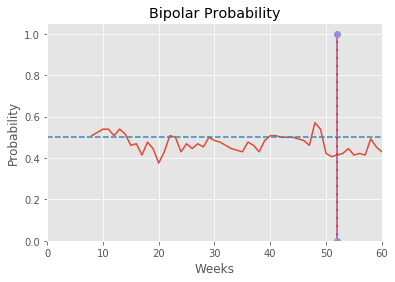

121
BaumG76
2016-05-12 00:00:00
2016-03-09 07:31:43
2016-08-04 19:15:26


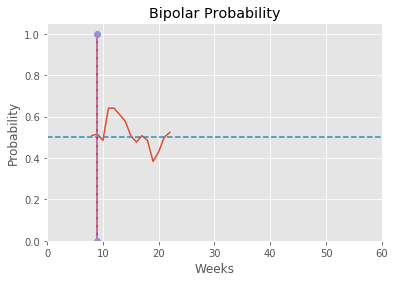

122
nidhighe
2013-05-29 00:00:00
2012-05-29 06:47:48
2013-08-29 17:07:21


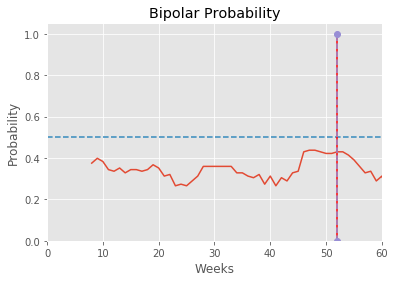

123
yohaw
2013-05-01 00:00:00
2012-05-01 08:33:39
2013-08-01 22:56:09


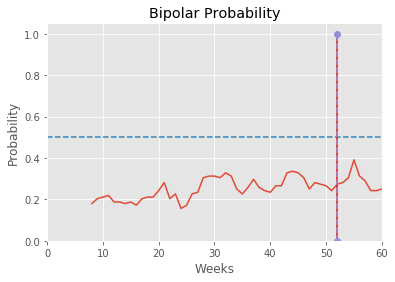

124
Luucekay
2017-01-16 00:00:00
2016-01-17 07:34:20
2017-02-07 02:41:38


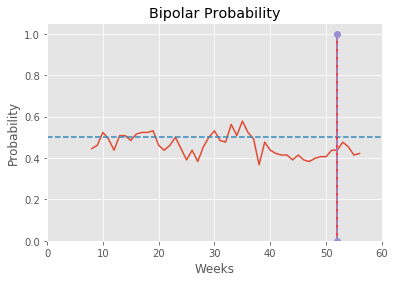

125
DeeJane7
2015-05-01 00:00:00
2014-05-06 07:45:28
2015-07-29 04:06:28


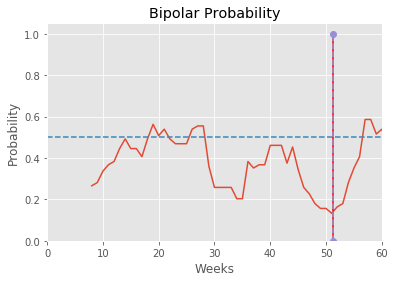

126
benjohnsick
2016-05-05 00:00:00
2015-05-07 23:35:49
2016-08-05 04:20:13


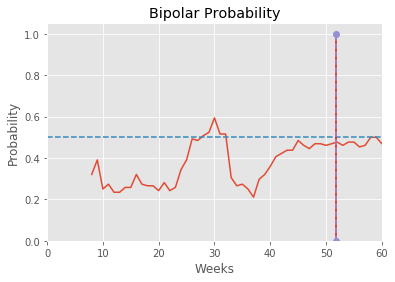

127
ObiWanChloe
2014-07-15 00:00:00
2013-07-15 10:18:09
2014-10-06 04:26:35


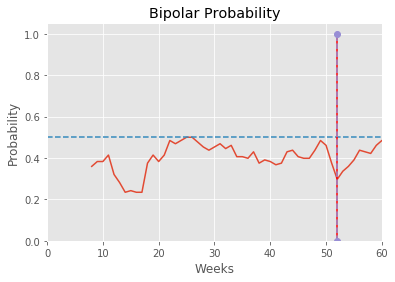

128
Empromancy
2015-01-01 00:00:00
2014-03-03 07:46:30
2015-01-16 02:47:06
129
lexeme
2015-06-12 00:00:00
2014-06-12 02:01:39
2015-09-12 22:11:47


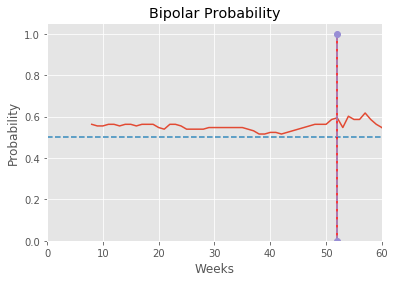

130
CamWillReadu
2015-05-25 00:00:00
2014-05-25 00:17:09
2015-08-25 23:33:42


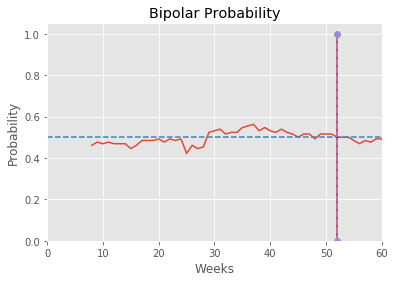

131
mikayla_radich
2014-01-01 00:00:00
2013-01-01 07:45:27
2014-04-01 13:07:28


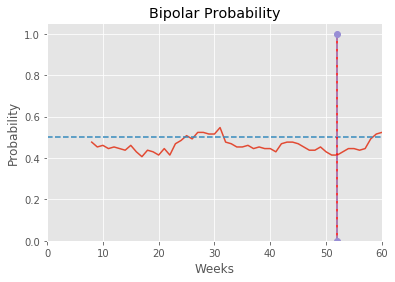

132
easytide
2014-03-21 00:00:00
2013-03-21 01:51:15
2014-06-21 23:47:29


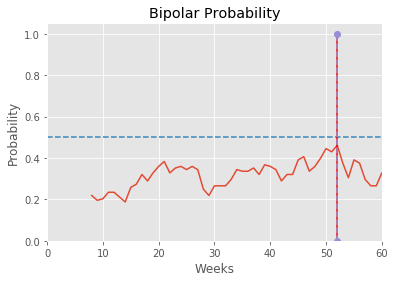

133
TIGN3Y
2016-11-08 00:00:00
2016-08-07 07:08:10
2016-12-29 08:10:03


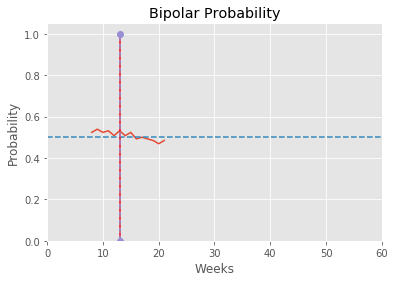

134
bunnyelephant
2016-12-01 00:00:00
2016-06-01 09:08:19
2017-02-06 18:45:06


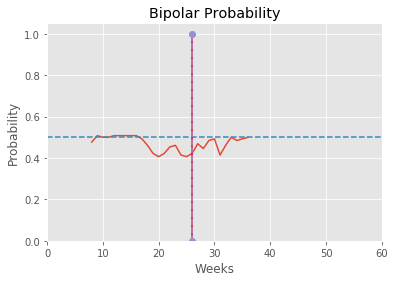

135
jimmypiper2
2013-11-19 00:00:00
2013-02-21 11:34:38
2014-02-19 18:38:42


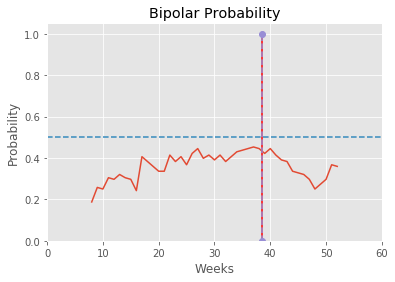

136
FinallyBipolar
2014-04-09 00:00:00
2014-04-25 04:37:17
2014-07-09 05:12:58


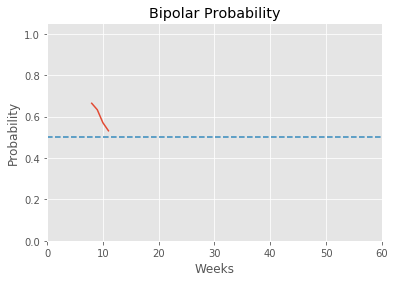

137
girlwtheblade
2012-12-01 00:00:00
2011-12-23 16:38:56
2013-02-24 13:10:17
138
nostaIgicmoons
2013-07-01 00:00:00
2013-04-21 23:36:01
2013-10-01 23:37:58


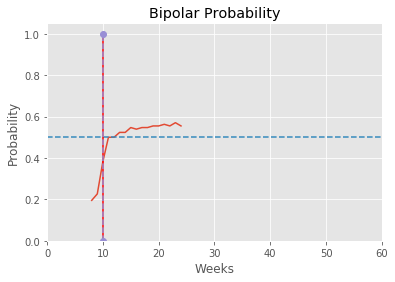

139
kierstingale
2014-01-01 00:00:00
2013-01-02 04:10:10
2014-04-01 10:55:23


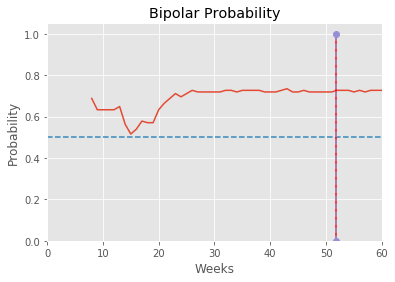

140
Nattyneou
2014-07-06 00:00:00
2013-07-07 00:22:34
2014-10-05 22:54:08


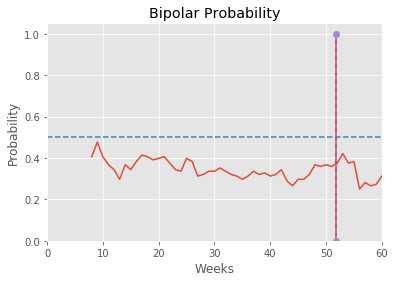

141
_weewee
2015-10-01 00:00:00
2014-10-01 07:56:54
2015-12-06 10:11:54


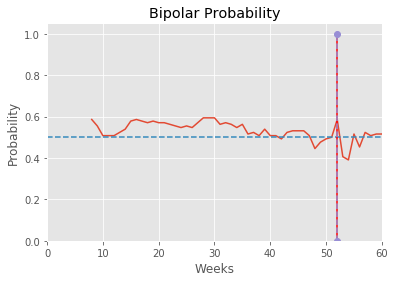

142
creeptrash
2014-11-01 00:00:00
2013-11-01 01:23:00
2015-02-01 18:06:00


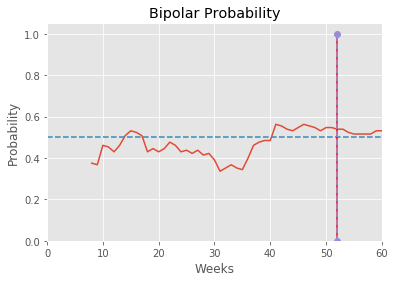

143
AshesAndSnow713
2015-01-15 00:00:00
2014-06-02 23:50:35
2015-04-06 23:14:02


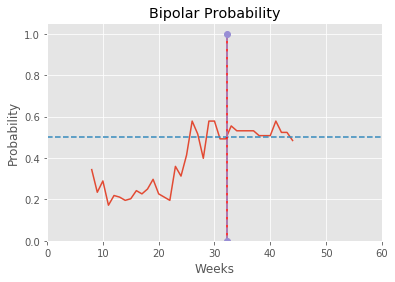

144
bromopoet
2015-07-01 00:00:00
2015-05-21 14:52:21
2015-09-05 13:35:07


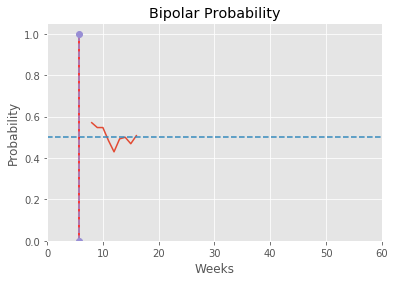

145
_rachelsarahxo
2016-11-15 00:00:00
2015-12-23 19:07:12
2017-02-06 21:56:19
146
edlukethird
2014-04-01 00:00:00
2013-04-04 05:11:31
2013-10-31 07:31:48


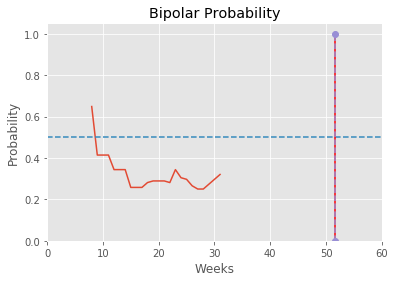

147
sbaestianstan
2015-09-01 00:00:00
2015-08-17 15:49:35
2015-12-01 23:46:43


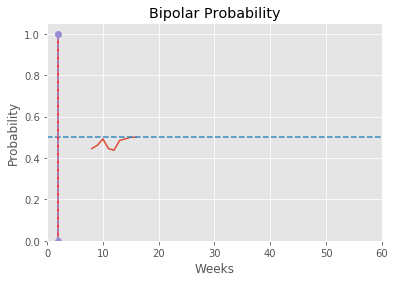

148
DemiLovatic5H
2016-04-08 00:00:00
2015-04-11 03:25:34
2016-07-02 22:30:16


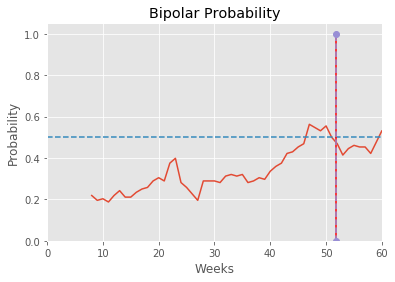

149
BattyBrilliance
2015-11-01 00:00:00
2015-09-07 20:56:15
2016-02-01 21:39:26


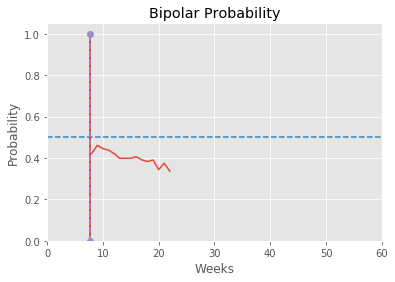

150
clyder1966
2013-10-01 00:00:00
2013-08-20 08:08:53
2013-12-23 07:38:39


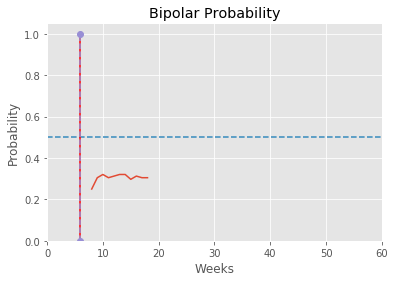

151
LochnessaMarie
2015-01-27 00:00:00
2014-01-31 13:47:14
2015-04-27 23:24:42


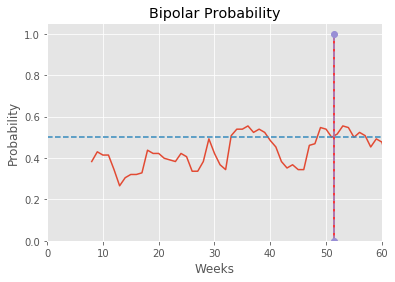

152
shiku___
2016-03-01 00:00:00
2015-03-11 10:58:41
2016-06-01 19:31:56


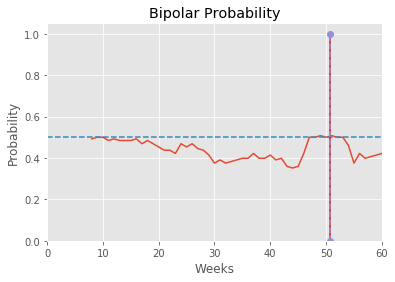

153
_FunSize_QT
2013-04-07 00:00:00
2012-04-07 01:58:20
2013-07-07 02:28:22


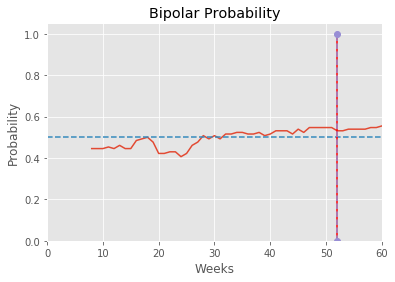

154
StephGambini
2014-04-03 00:00:00
2013-05-22 06:16:50
2014-07-03 13:45:30
155
JillianKarger
2013-08-01 00:00:00
2012-08-02 18:57:59
2013-10-13 20:56:26


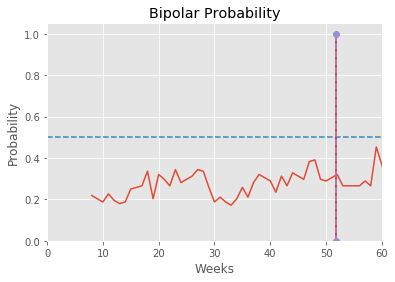

156
snowstormokami
2016-06-30 00:00:00
2016-06-24 11:01:38
2016-09-30 23:33:56


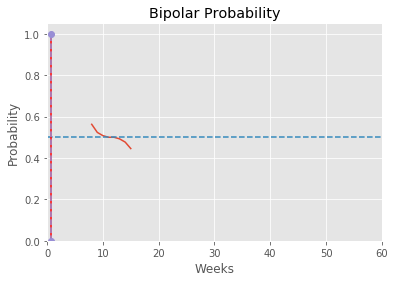

157
cuts4ndsc4rs
2013-04-26 00:00:00
2013-03-12 06:53:47
2013-05-28 03:26:20


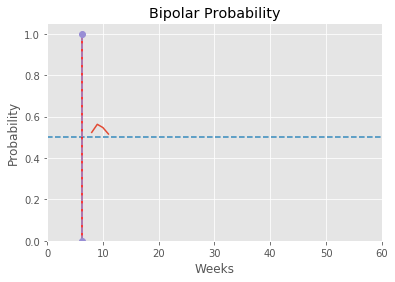

158
TWallaceMusic
2016-01-01 00:00:00
2015-01-25 18:01:21
2016-04-01 04:46:38


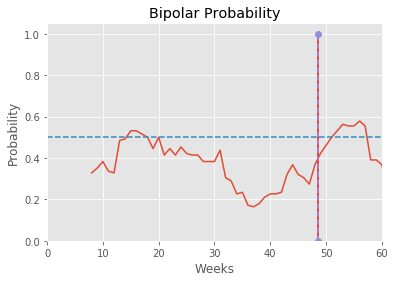

159
whippie3675
2016-01-22 00:00:00
2015-01-23 13:52:40
2016-04-19 23:38:33
160
CelticKaty88
2016-08-01 00:00:00
2015-08-01 09:01:55
2016-11-01 23:50:27


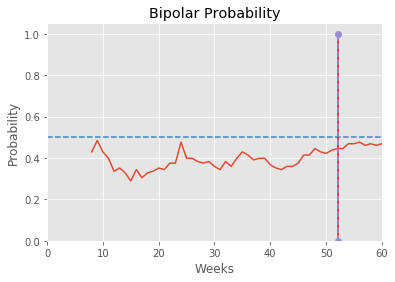

161
YangMummy
2013-01-01 00:00:00
2012-02-06 07:02:15
2013-04-01 19:27:43
162
razorblxde
2013-08-25 00:00:00
2013-01-27 02:26:32
2013-11-25 02:07:41


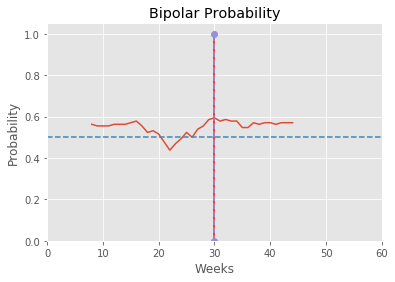

163
eds_shirtsleeve
2013-08-28 00:00:00
2012-08-28 00:02:50
2013-11-28 22:46:03


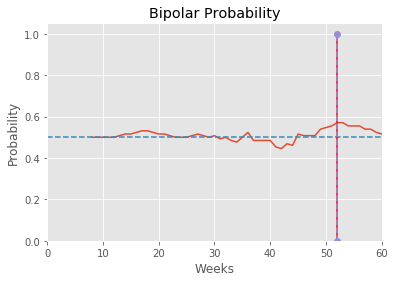

164
ganjasaurusr3x
2013-04-25 00:00:00
2013-03-04 10:58:04
2013-07-25 23:37:36


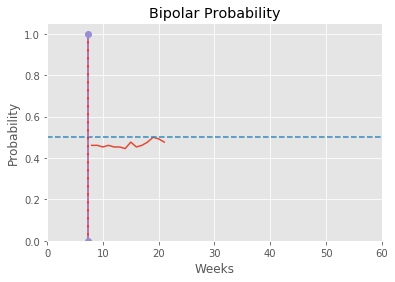

165
horrorvoid
2016-09-10 00:00:00
2015-09-11 03:09:37
2016-12-09 08:09:03


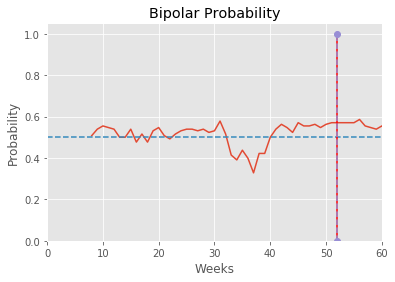

166
allagrugous
2015-06-18 00:00:00
2014-07-19 07:17:04
2015-09-18 23:13:37
167
MeridianRehab
2016-07-06 00:00:00
2015-10-10 05:00:00
2016-10-06 21:30:55


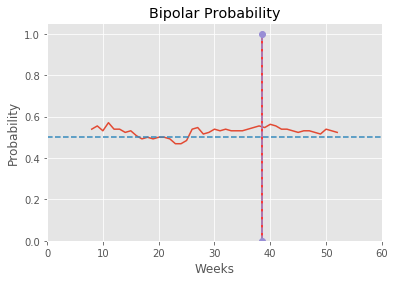

168
Oello12
2013-03-01 00:00:00
2012-03-01 14:38:33
2013-06-01 16:37:00


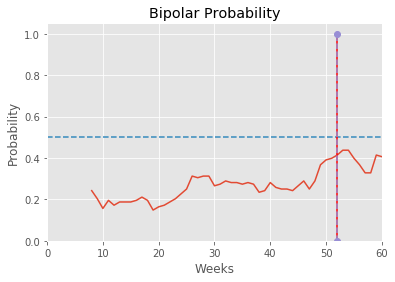

169
enjoyscarlett_
2015-04-03 00:00:00
2014-04-03 00:29:29
2015-07-03 23:28:04


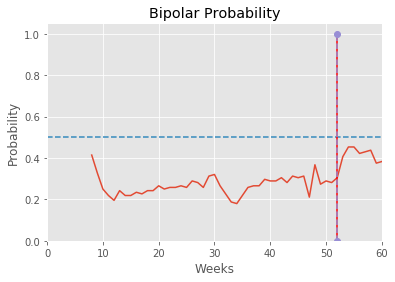

170
recoveryspirit
2014-05-08 00:00:00
2013-05-08 00:00:17
2014-08-08 23:59:07


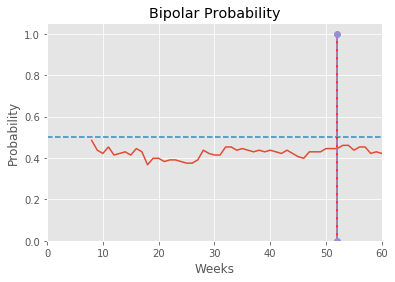

171
mattstreuli
2015-05-22 00:00:00
2014-05-22 02:02:40
2015-08-22 22:05:22


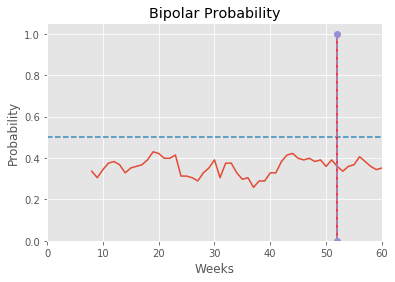

172
TinyLittleChen
2014-10-20 00:00:00
2013-10-20 00:02:43
2015-01-20 18:09:44


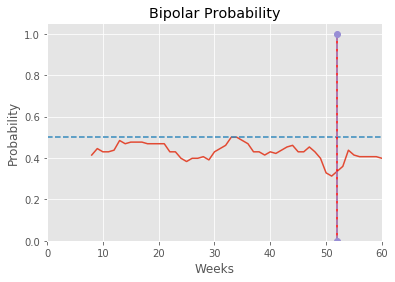

173
Lesism
2014-09-01 00:00:00
2013-09-01 00:04:46
2014-12-01 20:57:00


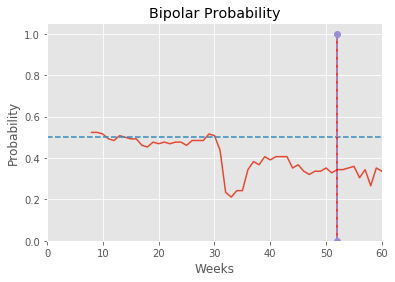

174
TheInsaneIdol
2014-03-01 00:00:00
2013-03-15 05:26:41
2014-05-31 22:36:30


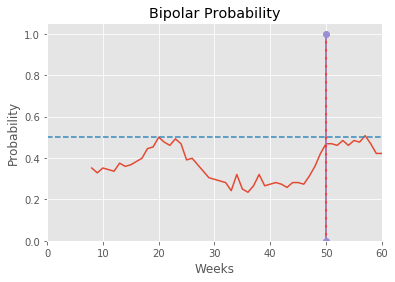

175
Megrrrs
2015-12-09 00:00:00
2014-12-09 00:09:42
2016-03-09 02:01:46


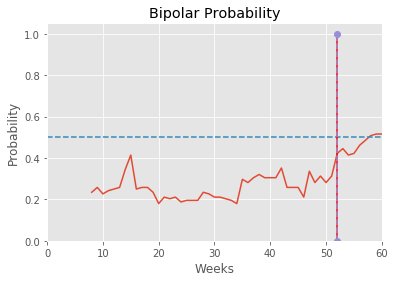

176
_kenziiieee_
2016-03-04 00:00:00
2015-03-06 17:50:05
2016-06-02 23:08:58


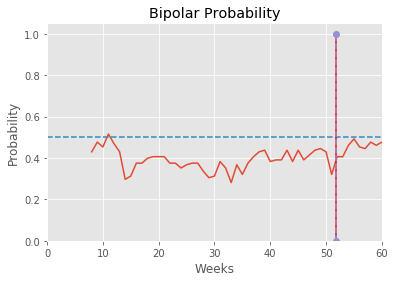

177
hamburgerphone
2016-11-09 00:00:00
2015-11-09 03:54:32
2016-12-29 04:46:47


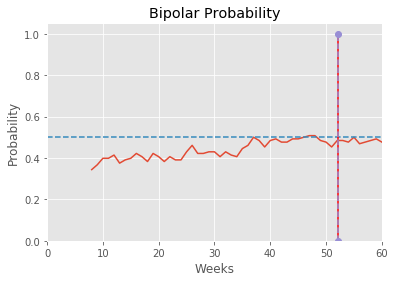

178
__bmorris
2013-04-01 00:00:00
2012-05-21 10:20:35
2013-07-01 16:02:23


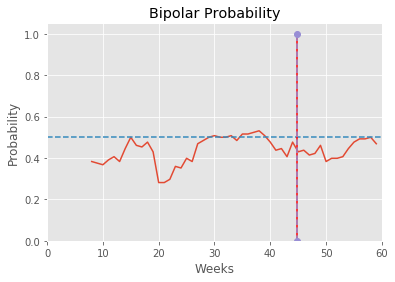

179
Moziee22
2016-07-20 00:00:00
2016-06-02 17:50:03
2016-10-19 14:21:40


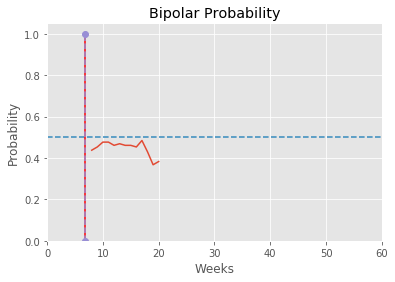

180
LonerBelle
2015-05-21 00:00:00
2014-05-29 15:40:23
2015-07-30 17:44:46


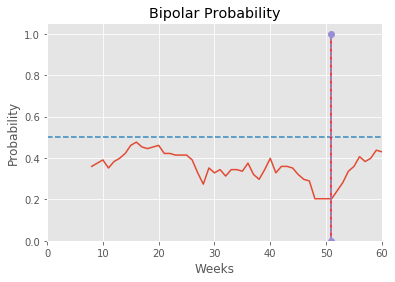

181
BrianCrimson
2014-07-01 00:00:00
2013-07-01 00:13:10
2014-10-01 17:46:35


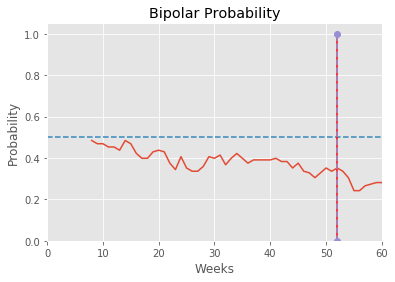

In [21]:
# Old